In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchmetrics
import zarr
from scipy.io import mmread

In [2]:
def normalize_counts(x, normlib=True, logscale=True):
    if normlib:
        ## compare with normalized true profile
        lib = x.sum(axis=1, keepdims=True)
        x = x / lib
    if logscale:
        x = np.log1p(x)
    return x


def corr_obs_reocnstr(x, y, per_gene=True, data_type="RNA", plot=False):
    num_genes, num_cells = x.shape[1], y.shape[0]

    x, y = torch.from_numpy(x), torch.from_numpy(y)

    if per_gene:
        pearson = torchmetrics.PearsonCorrCoef(num_outputs=num_genes)
        corr = pearson(x, y)
        if plot:
            sns.histplot(corr)
            if data_type == "RNA":
                plt.title("Correlation across cells for each gene")
            else:
                plt.title("Correlation across cells for each peak")
            plt.xlabel(f"mean: {corr.mean():.3f}")
            plt.show()

    if per_gene == False:
        pearson = torchmetrics.PearsonCorrCoef(num_outputs=num_cells)
        corr = pearson(x.T, y.T)
        if plot:
            sns.histplot(corr)
            if data_type == "RNA":
                plt.title("Correlation across genes for each cell")
            else:
                plt.title("Correlation across peaks for each cell")
            plt.xlabel(f"mean: {corr.mean():.3f}")
            plt.show()
    return corr

In [3]:
data_dir = "/data/mikulik/PolarbearPlus/notebooks/data/"

In [4]:
# read in barcodes, gene names and peak names
snareseq_barcodes = pd.read_csv(
    os.path.join(data_dir, "snareseq/adultbrainfull50_atac_outer_snareseq_barcodes.tsv"), sep="\t"
)
snareseq_genes = pd.read_csv(os.path.join(data_dir, "snareseq/adultbrainfull50_rna_outer_genes.txt"), sep="\t")
snareseq_peaks = pd.read_csv(
    os.path.join(data_dir, "snareseq/adultbrainfull50_atac_outer_peaks.txt"), sep="\t", header=None
)
snareseq_peaks.columns = ["peaks"]
snareseq_peaks["ind"] = snareseq_peaks.index

In Polarbears they computed the correlations only based on differentially expressed genes. 

In [5]:
# read in diff genes
diff_genes = pd.read_excel(
    os.path.join(data_dir, "diffexp/NIHMS1539957-supplement-sup_tab1.xlsx"),
    sheet_name="Adult_cerebral_cortex",
    header=3,
)
gene_names = pd.read_csv(os.path.join(data_dir, "diffexp/adultbrainfull50_rna_outer_genes.txt"), sep="\t", header=None)
gene_names.columns = ["gene"]
gene_names["ind"] = np.arange(len(gene_names))
diff_genes_ind = gene_names[gene_names.gene.isin(diff_genes.Gene.unique())]["ind"]

In [6]:
tmp = gene_names[gene_names.ind.isin(diff_genes_ind)].gene
# gene_names.Gene

In [7]:
# get the index of cells in the test set that were retained during model training
true_split = pd.read_csv(os.path.join(data_dir, "split/idx_test.txt"), sep="\t", header=None)
true_split.columns = ["idx"]

In [8]:
# get cell type annotations from snareseq
cell_names = pd.read_csv(os.path.join(data_dir, "diffexp/snareseq_anno.csv"), index_col=0)
cell_names = cell_names.loc[snareseq_barcodes["index"]]
# change order of cell names so they comply with the test set
test_cell_names = cell_names.iloc[true_split.idx.tolist()]
test_cell_names.Ident.unique()

array(['OliM', 'Mis', 'E3Rorb', 'E2Rasgrf2', 'Ast', 'E3Rmst',
       'E4Il1rapl2', 'E4Thsd7a', 'Clau', 'E5Galnt14', 'InN', 'E6Tle4',
       'E5Sulf1', 'InS', 'E5Tshz2', 'InP', 'E5Parm1', 'InV', 'Mic', 'OPC',
       'OliI', 'Endo', 'Peri'], dtype=object)

In [9]:
## Read observed RNA and ATAC counts
# rna_counts = mmread(os.path.join("/data/mikulik/PolarbearPlus/notebooks/data/snareseq/adultbrainfull50_rna_outer_snareseq.mtx")).tocsr().astype(np.float32).toarray().squeeze()
## subset to keep only test set cell
# obs_rna = rna_counts[true_split.idx.tolist(), :]
#
# atac_counts = mmread(os.path.join("/data/mikulik/PolarbearPlus/notebooks/data/snareseq/adultbrainfull50_atac_outer_snareseq.mtx")).tocsr().astype(np.float32).toarray().squeeze()
## subset to keep only test set cells
# obs_atac = atac_counts[true_split.idx.tolist(), :]
# print(obs_rna.shape, obs_atac.shape)


In [10]:
# Read observed RNA and ATAC counts
rna_counts = (
    mmread(os.path.join("/data/mikulik/PolarbearPlus/notebooks/data/snareseq/adultbrainfull50_rna_outer_snareseq.mtx"))
    .tocsr()
    .astype(np.float32)
    .toarray()
    .squeeze()
)
# subset to keep only test set cell
obs_rna = rna_counts[true_split.idx.tolist(), :]

atac_counts = (
    mmread(os.path.join("/data/mikulik/PolarbearPlus/notebooks/data/snareseq/adultbrainfull50_atac_outer_snareseq.mtx"))
    .tocsr()
    .astype(np.float32)
)
atac_counts.data[:] = 1  # set all non-zero values to 1
atac_counts = atac_counts.toarray()  # .squeeze()
# subset to keep only test set cells
obs_atac = atac_counts[true_split.idx.tolist(), :]
print(obs_rna.shape, obs_atac.shape)

(2061, 17271) (2061, 225333)


In [11]:
sheet_names = [
    "Ast",
    "Claustrum",
    "Ex-L23-Rasgrf2",
    "Ex-L34-Rmst",
    "Ex-L34-Rorb",
    "Ex-L45-Il1rapl2",
    "Ex-L45-Thsd7a",
    "Ex-L5-Galnt14",
    "Ex-L5-Parm1",
    "Ex-L56-Sulf1",
    "Ex-L56-Tshz2",
    "Ex-L6-Tle4",
    "In-Npy",
    "In-Pvalb",
    "In-Sst",
    "In-Vip",
    "Oli-Itpr2",
    "Oli-Mal",
    "OPC",
    "Endo",
    "Peri",
    "Mic",
]
len(sheet_names), test_cell_names.Ident.nunique()

diff_peak_list = []
for i in sheet_names:
    if i == "Ast":
        diff_peaks = pd.read_excel("data/diffexp/NIHMS1539957-supplement-sup_tab3.xlsx", sheet_name=i, header=3)
    else:
        diff_peaks = pd.read_excel("data/diffexp/NIHMS1539957-supplement-sup_tab3.xlsx", sheet_name=i, header=0)
        # print(diff_peaks)
    diff_peaks["peaks"] = (
        diff_peaks.chrom.astype("str") + ":" + diff_peaks.start.astype("str") + "-" + diff_peaks.end.astype("str")
    )
    diff_peak_list = diff_peak_list + diff_peaks.peaks.tolist()
print(len(diff_peak_list))
print(f"Unique: {len(set(diff_peak_list))}")

diff_peaks_ind = snareseq_peaks[snareseq_peaks.peaks.isin(diff_peak_list)].ind.tolist()

79520
Unique: 67328


# Functions

In [12]:
data_dir = "/data/mikulik/mnt_polarbear_exp/"

In [13]:
def index_1d_to_2d(index, width):
    row = index // width
    col = index % width
    return row, col


def get_index_array(x):
    ind_arr = np.arange(x.flatten().shape[0]).reshape(x.shape)
    return ind_arr

In [14]:
def scale_quantiles(counts, q025, q975):
    condition = counts > 0
    obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])
    return obs_scale

In [15]:
def read_vae(data_dir, vae="rnavae"):
    x = zarr.open(os.path.join(data_dir, vae, "settings_polarbear/prediction/stats.zarr"), mode="r")
    q025 = np.asarray(x["reconstruction_stats"]["q0.025"])
    q975 = np.asarray(x["reconstruction_stats"]["q0.975"])
    # obs_norm =obs_rna/obs_rna.sum(axis=1, keepdims=True)
    # print(q025.min(), q025.max())
    return q025, q975


def read_translator(data_dir, translator, file):
    x = zarr.open(os.path.join(data_dir, translator, file, "prediction/stats.zarr"))
    q025, q95, q975 = np.asarray(x["q0.025"]), np.asarray(x["q0.95"]), np.asarray(x["q0.975"])
    return q025, q975

In [16]:
def plot_ci(obs_scale, title=""):
    sns.histplot(obs_scale)
    plt.axvline(1, color="black")
    plt.axvline(0, color="black")
    plt.title(f"{title}")
    plt.show()

In [17]:
def load_latent_embeddings(zarr_file_path):
    x = zarr.open(os.path.join(zarr_file_path, "prediction/stats.zarr"), mode="r")
    latent = np.asarray(x["latent_0"])
    return latent

In [18]:
def get_reconstructed_counts(zarr_file):
    zarr_file = os.path.join(zarr_file, "prediction/stats.zarr")
    a = zarr.open(zarr_file, mode="r")
    return a["reconstruction_stats"]["mean"], a["reconstruction_stats"]["var"]


def get_reconstructed_cross_modality(zarr_file):
    zarr_file = os.path.join(zarr_file, "prediction/stats.zarr")
    a = zarr.load(zarr_file)
    return a["mean"], a["var"]

In [19]:
# RNAVAE predictions
mean_pred_rna, var_pred_rna = get_reconstructed_counts("/data/mikulik/mnt_polarbear_exp/rnavae/settings_polarbear")
mean_pred_rna, var_pred_rna = torch.from_numpy(np.asarray(mean_pred_rna)), torch.from_numpy(np.asarray(var_pred_rna))

# ATACVAE predictions
mean_pred_atac, var_pred_atac = get_reconstructed_counts("/data/mikulik/mnt_polarbear_exp/atacvae/settings_polarbear")
mean_pred_atac, var_pred_atac = (
    torch.from_numpy(np.asarray(mean_pred_atac)),
    torch.from_numpy(np.asarray(var_pred_atac)),
)

# MLP Trnaslator ATAC2RNA
mean_pred_mlp_rna, var_pred_mlp_rna = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_atac2rna/"
)

# MLP Trnaslator SANE ATAC2RNA
mean_pred_mlp_rna_sane, var_pred_mlp_rna_sane = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_sane_atac2rna/"
)

# MLP Translator RNA2ATAC
mean_pred_mlp_atac, var_pred_mlp_atac = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_rna2atac"
)

mean_pred_inn_rna, var_pred_inn_rna = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/inntranslator/latent_atac2rna_v1"
)

In [20]:
# def plot_pred_vs_obs_ct(data_dict, title="Mean", clip=True):
#    if clip:
#        print("Clipping data to 95% quantile")
#    fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 20))
#    for i, name in enumerate(data_dict.keys()):
#        n_cells = len(test_cell_names[test_cell_names.Ident == name])
#        x, y = data_dict[name]
#        if clip:
#            clip_x, clip_y = np.round(np.quantile(x, 0.95)), np.round(np.quantile(y, 0.95))
#            x, y = np.clip(x, 0, clip_x), np.clip(y, 0, clip_y)
#        xlim = [min(x.min(), y.min()), max(x.max(), y.max())]
#        row, col = i // 3, i % 3
#        ax = axes[row, col]
#        ax.scatter(x=x, y=y, s=4)
#        ax.plot(xlim, xlim, color='black', linestyle='--')
#        ax.set_title(f"{name}, n_cells: {n_cells}")
#
#
#    # Set shared x-axis label
#    fig.supxlabel(f"{title}, observed")
#    fig.supylabel(f"{title}, predicted")
#
#    plt.subplots_adjust(top=1, bottom=0.2, hspace=0.5)
#    #fig.suptitle(title)
#    plt.show()

In [21]:
save_fig_dir = "/data/mikulik/PolarbearPlus/notebooks/figures/"

In [22]:
def plot_pred_vs_obs_ct(data_dict, title="Mean", clip=True, savefig=None):
    if clip:
        print("Clipping data to 95% quantile")
    fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 20))
    for i, name in enumerate(data_dict.keys()):
        n_cells = len(test_cell_names[test_cell_names.Ident == name])
        x, y = data_dict[name]
        if clip:
            clip_x, clip_y = np.quantile(x, 0.95), np.quantile(y, 0.95)
            x, y = np.clip(x, 0, clip_x), np.clip(y, 0, clip_y)
        xlim = [min(x.min(), y.min()), max(x.max(), y.max())]
        row, col = i // 3, i % 3
        ax = axes[row, col]
        ax.scatter(x=x, y=y, s=4)
        ax.plot(xlim, xlim, color="black", linestyle="--")
        ax.set_title(f"{name}, n_cells: {n_cells}")

    # Set shared x-axis label
    fig.supxlabel(f"{title}, observed")
    fig.supylabel(f"{title}, predicted")
    fig.tight_layout()
    # plt.subplots_adjust(top=1, bottom=0.2, hspace=0.5)
    # fig.suptitle(title)
    if savefig is not None:
        plt.savefig(os.path.join(savefig, f"{title}.pdf"))
    plt.show()

In [23]:
def get_mean_var_per_ct(test_cell_names, diff_genes_ind, obs, pred):
    tmp_mean, tmp_var = {}, {}
    for cell_type in test_cell_names.Ident.unique():
        # observations
        rna_ct = obs[test_cell_names.Ident == cell_type, :]
        rna_ct = rna_ct[:, diff_genes_ind]
        # print(rna_ct.shape)
        obs_mean, obs_var = rna_ct.mean(axis=0), rna_ct.var(axis=0)
        # print(obs_mean.shape, obs_var.shape)

        # predictions
        pred_ct = pred[(test_cell_names.Ident == cell_type).tolist(), :]
        pred_ct = pred_ct[:, diff_genes_ind.tolist()]
        pred_mean, pred_var = pred_ct.mean(axis=0), pred_ct.var(axis=0)
        # print(pred_var.max(), obs_var.max(), obs_var.mean())
        # print(obs_mean.mean(), np.round(np.quantile(obs_mean, 0.95)))

        tmp_mean[cell_type] = (obs_mean, pred_mean)
        tmp_var[cell_type] = (obs_var, pred_var)
    return tmp_mean, tmp_var

settings_polarbear_atac2rna
/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_atac2rna/prediction/stats.zarr
Clipping data to 95% quantile


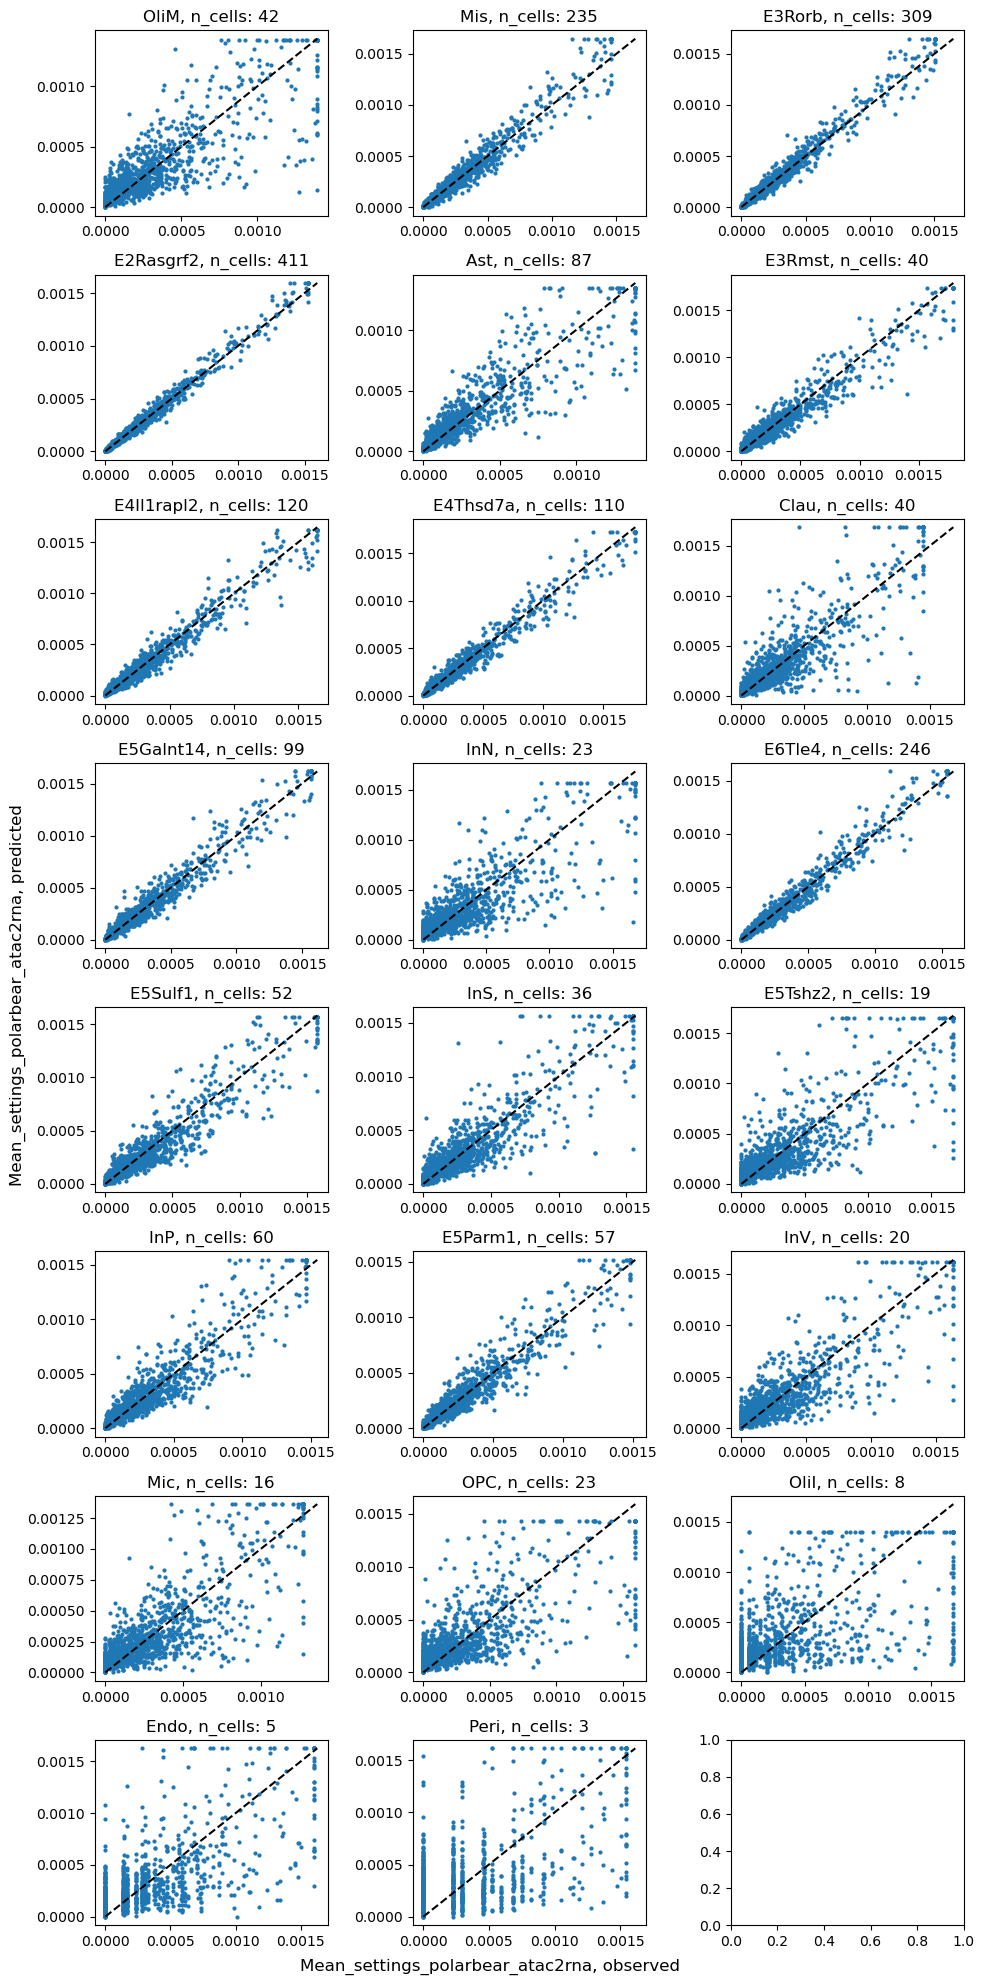

Clipping data to 95% quantile


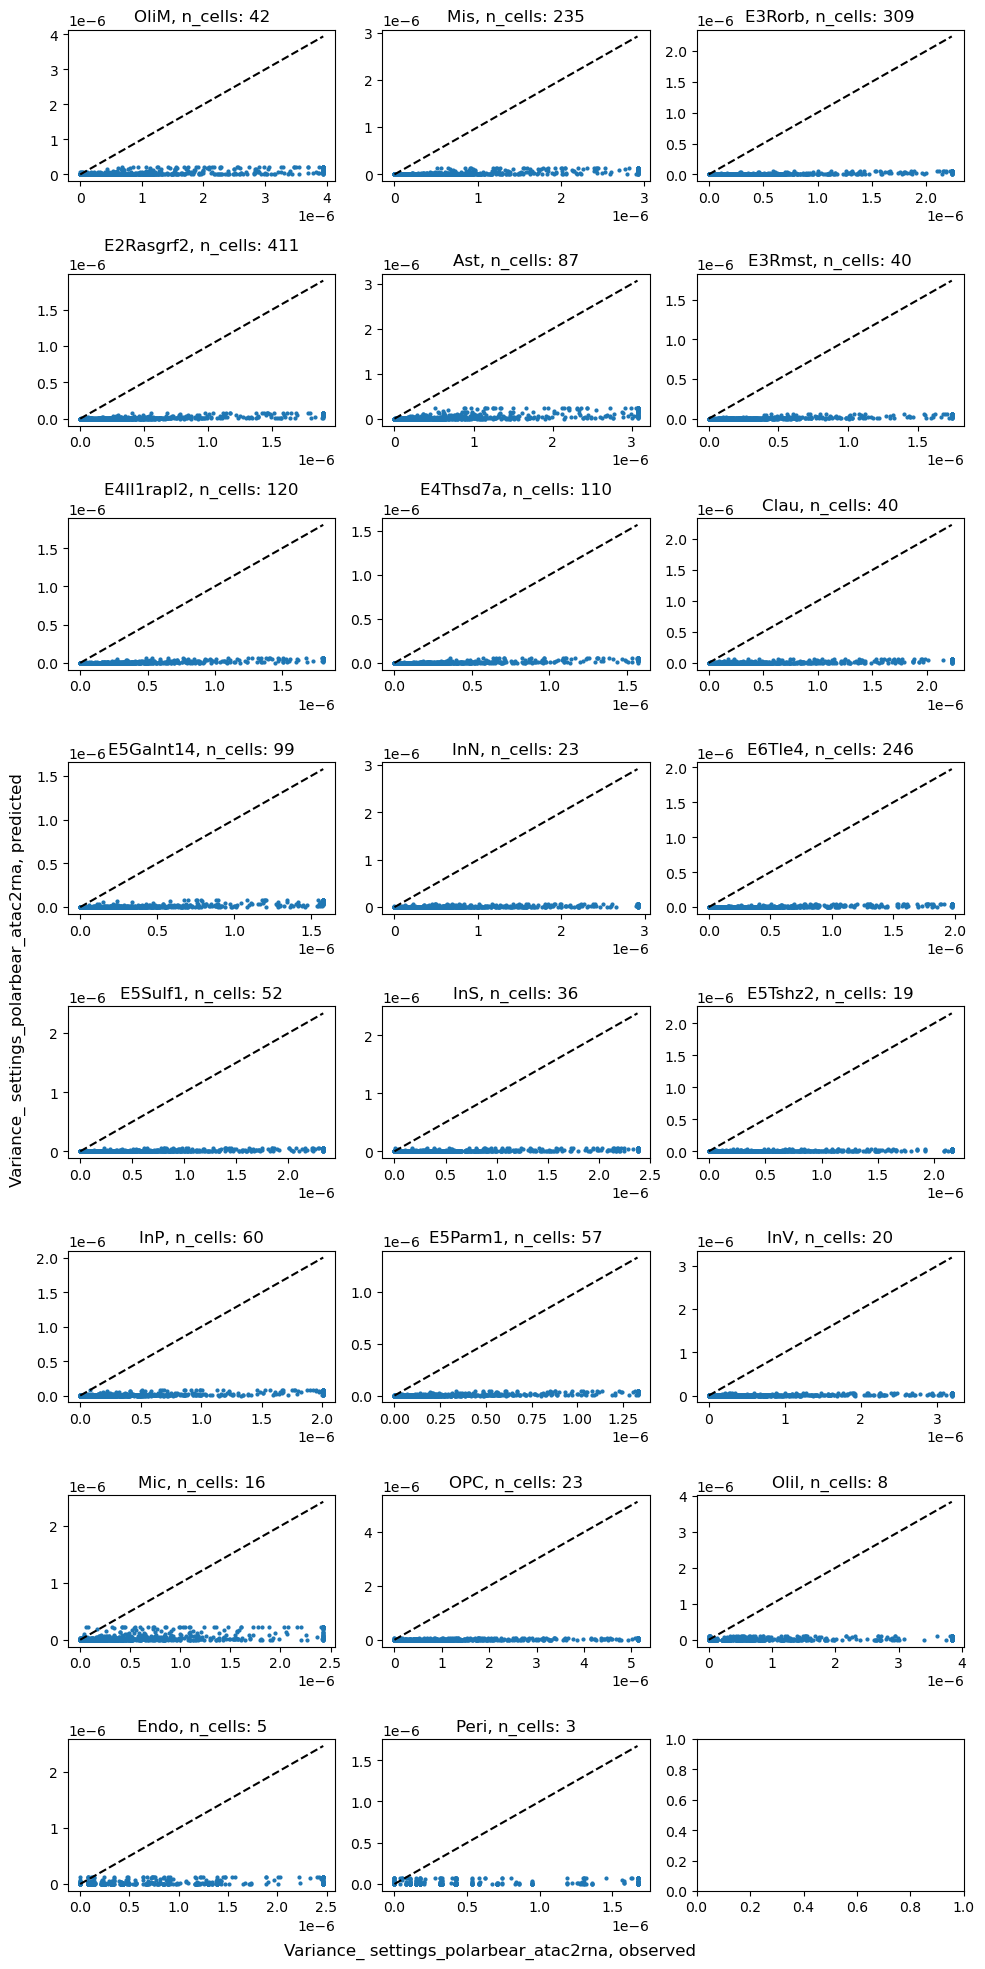

settings_sane_atac2rna
/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_sane_atac2rna/prediction/stats.zarr
Clipping data to 95% quantile


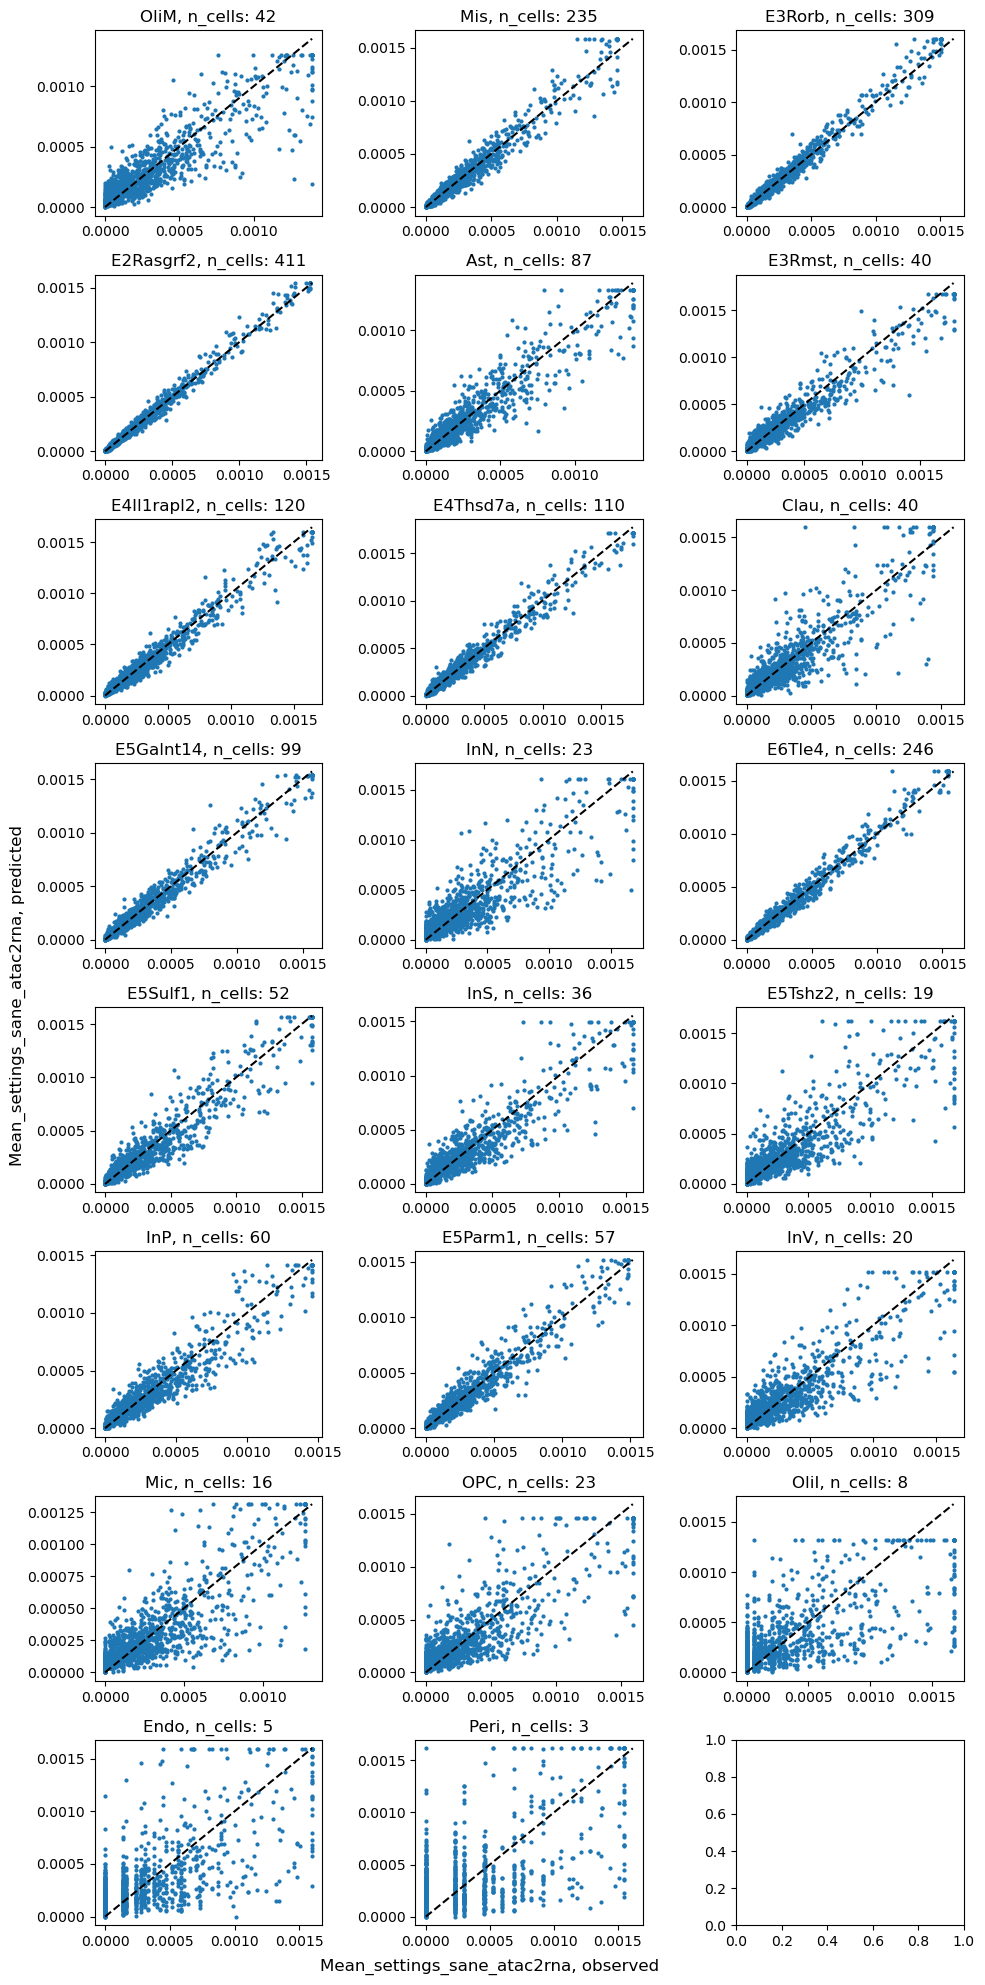

Clipping data to 95% quantile


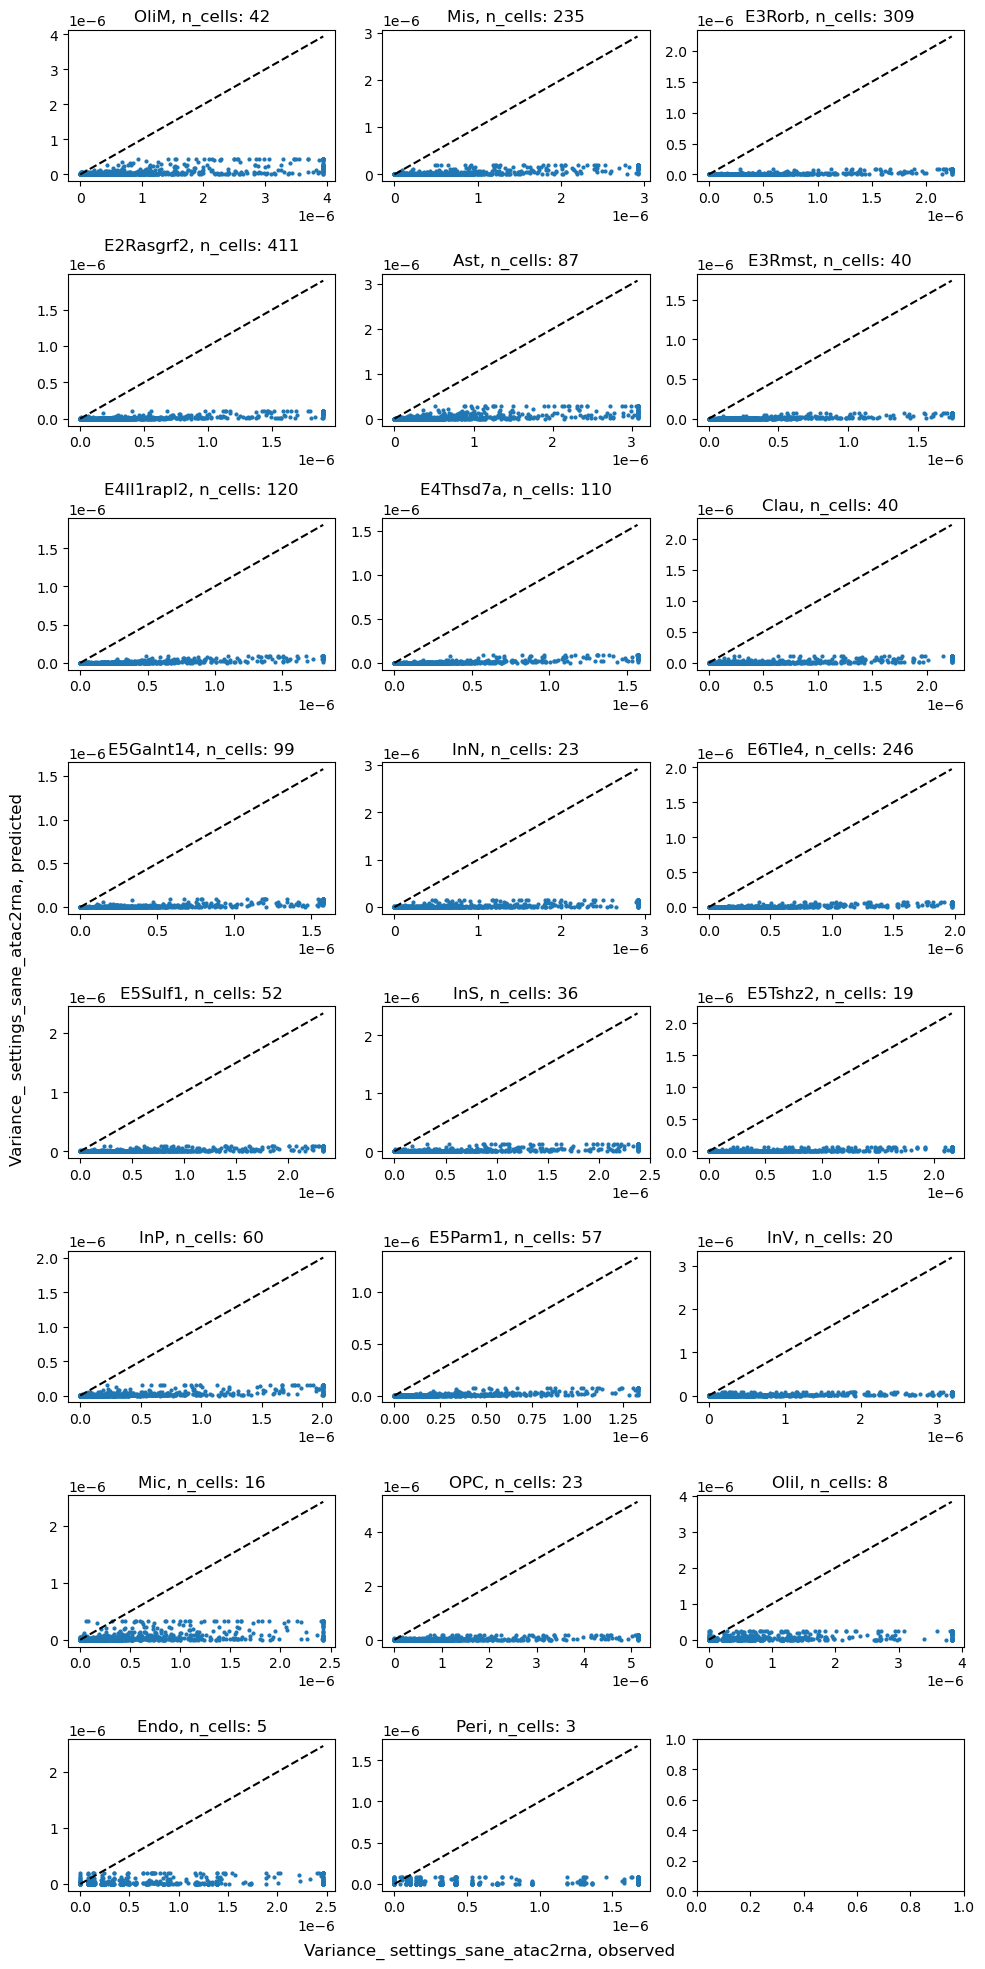

doublesample_atac2rna_v1
/data/mikulik/mnt_polarbear_exp/inntranslator/doublesample_atac2rna_v1/prediction/stats.zarr
Clipping data to 95% quantile


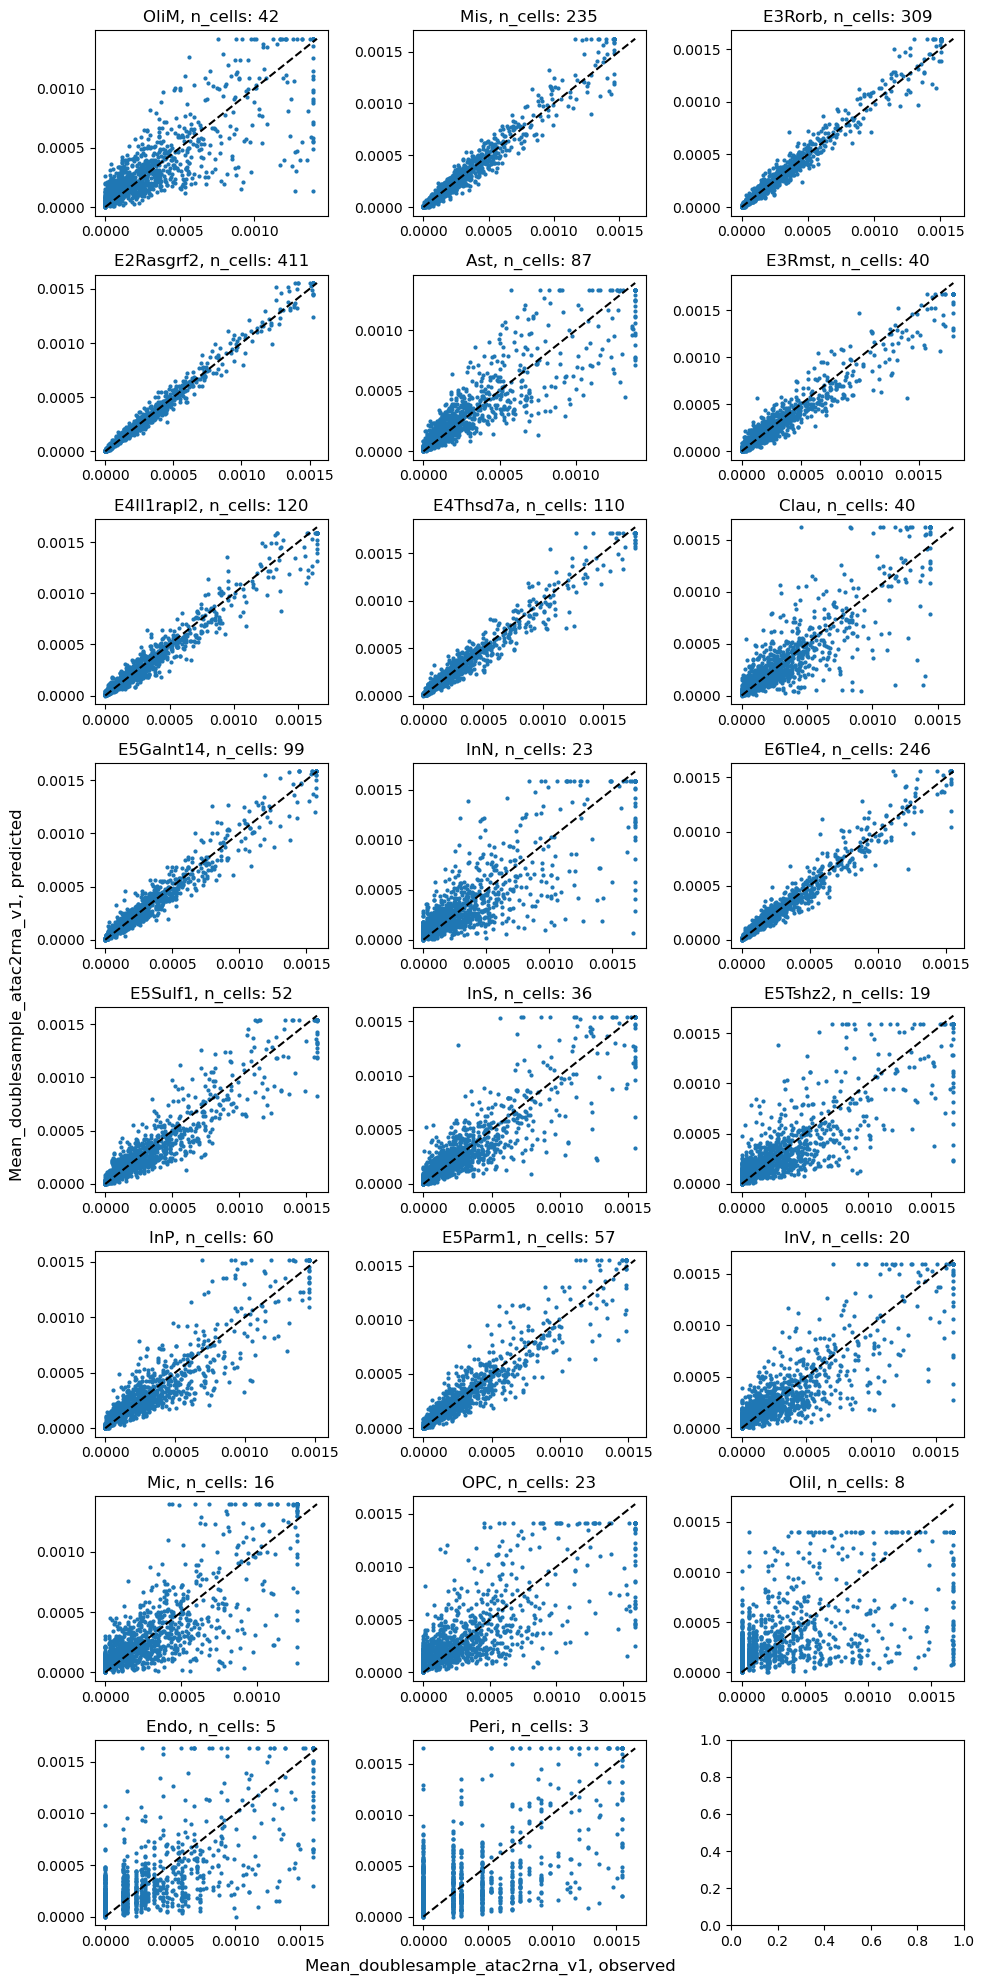

Clipping data to 95% quantile


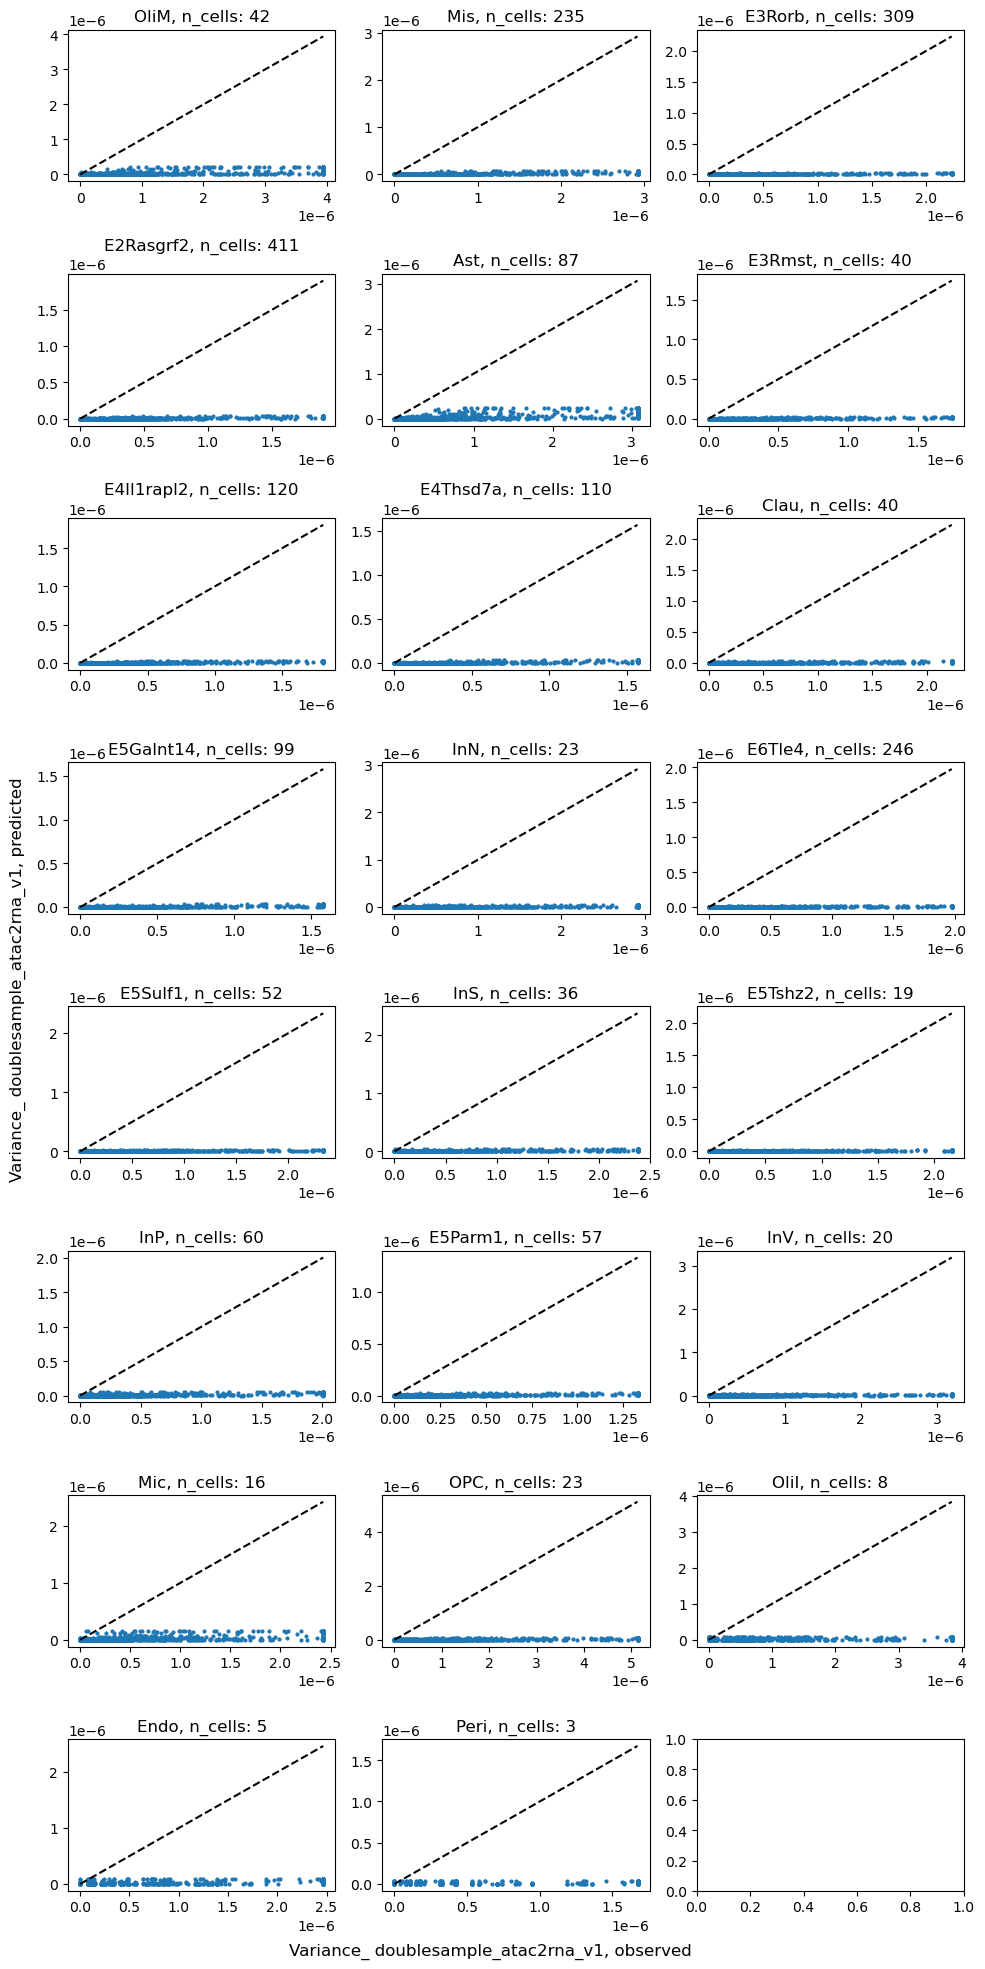

latent_atac2rna_v1
/data/mikulik/mnt_polarbear_exp/inntranslator/latent_atac2rna_v1/prediction/stats.zarr
Clipping data to 95% quantile


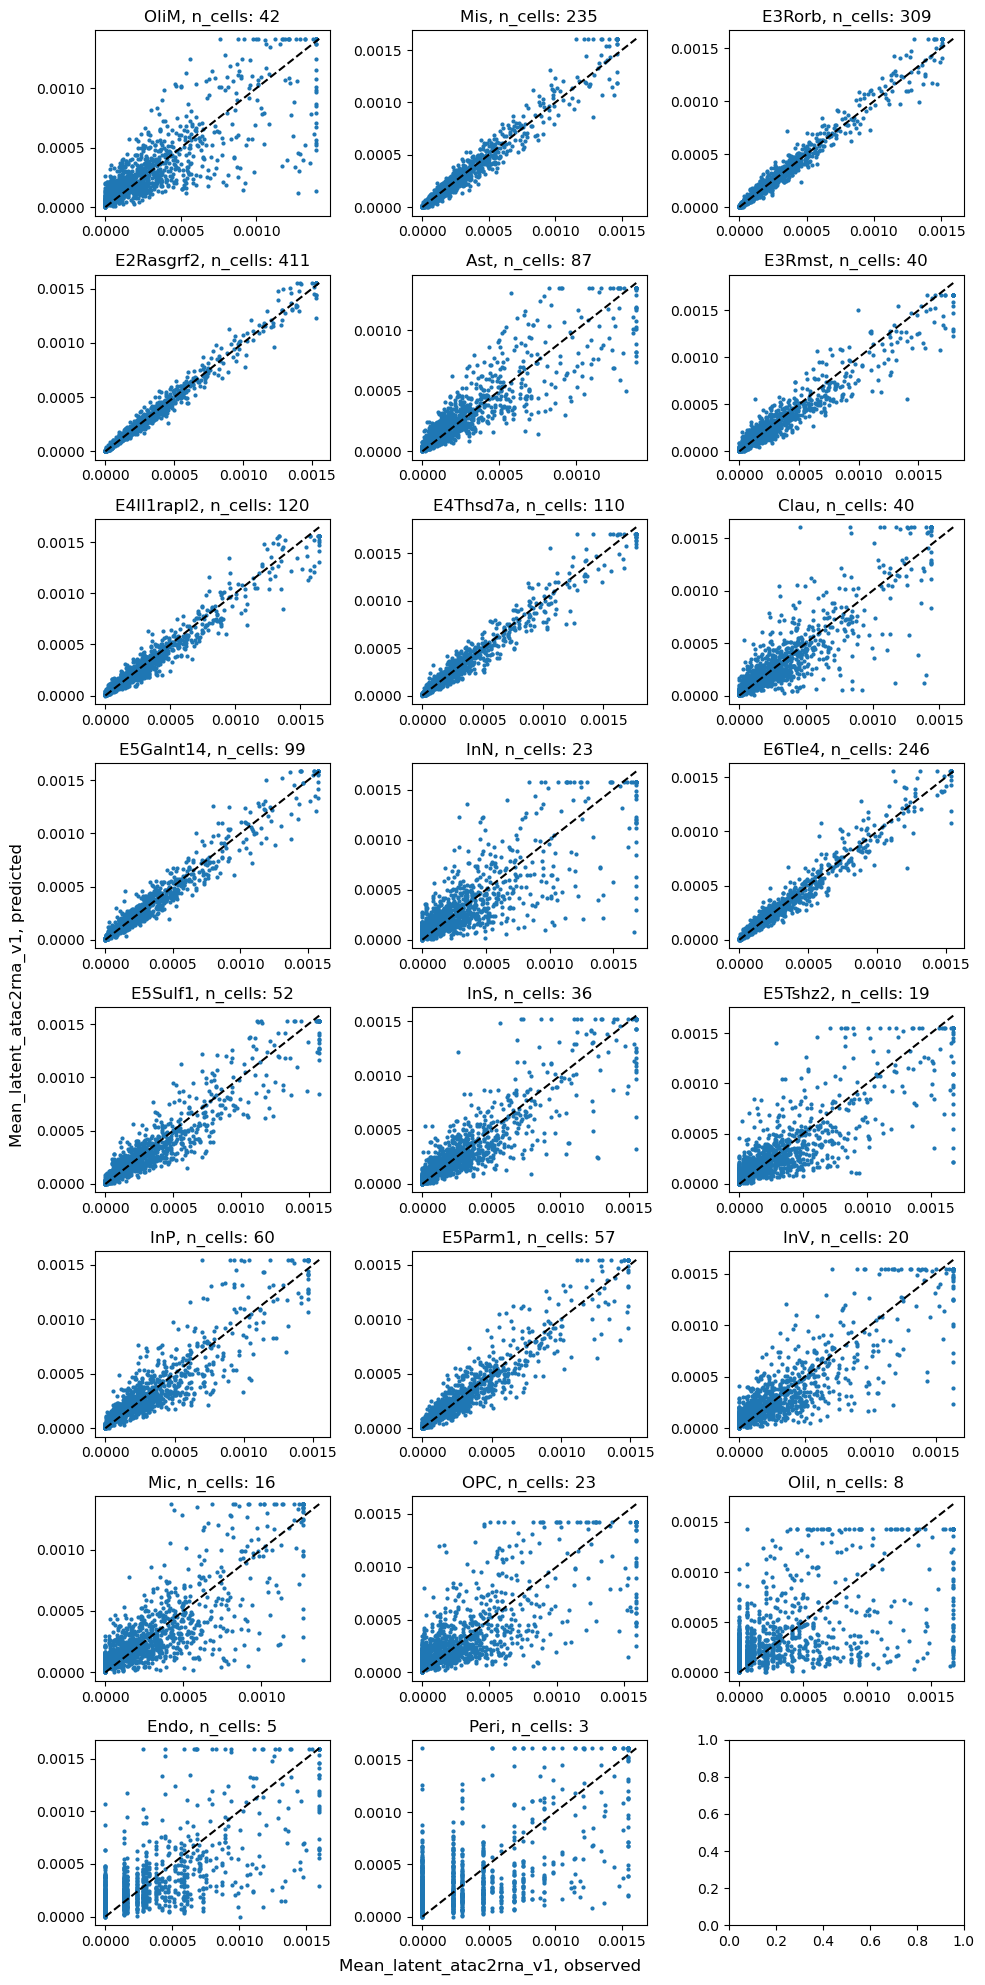

Clipping data to 95% quantile


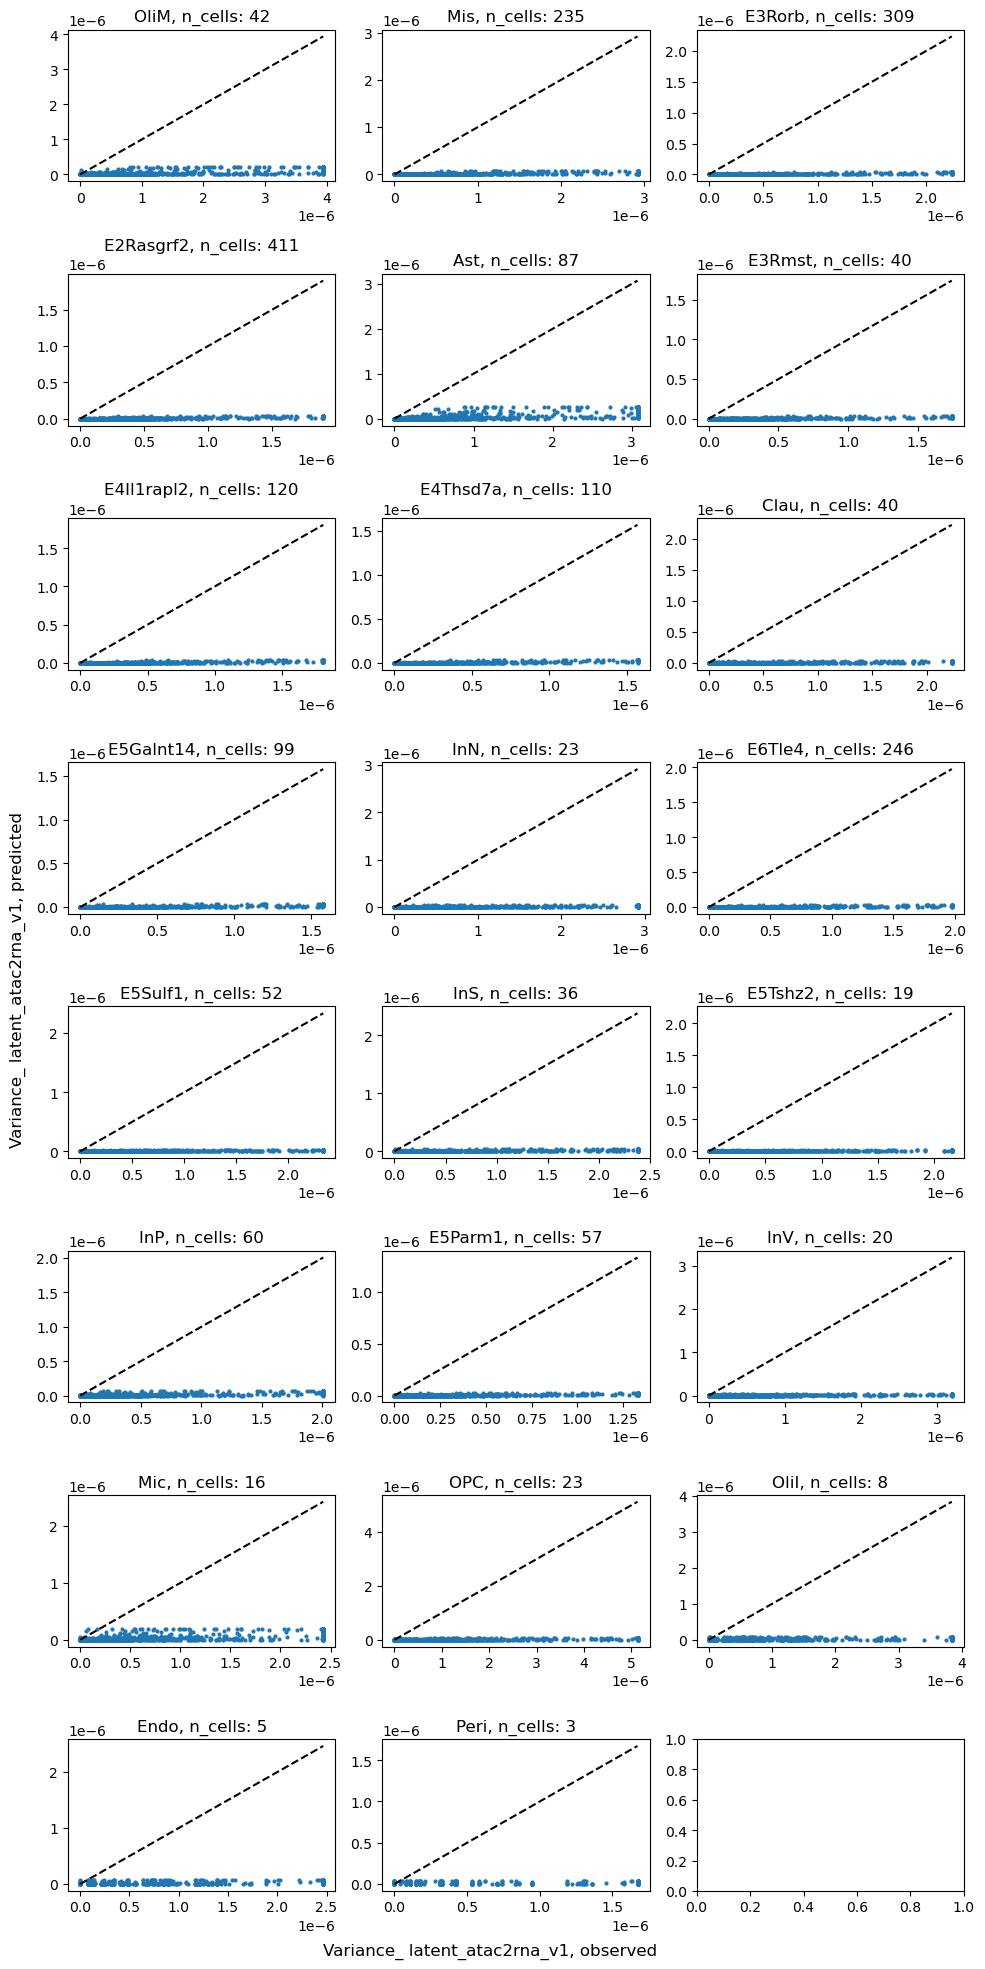

sample_atac2rna_v1
/data/mikulik/mnt_polarbear_exp/inntranslator/sample_atac2rna_v1/prediction/stats.zarr
Clipping data to 95% quantile


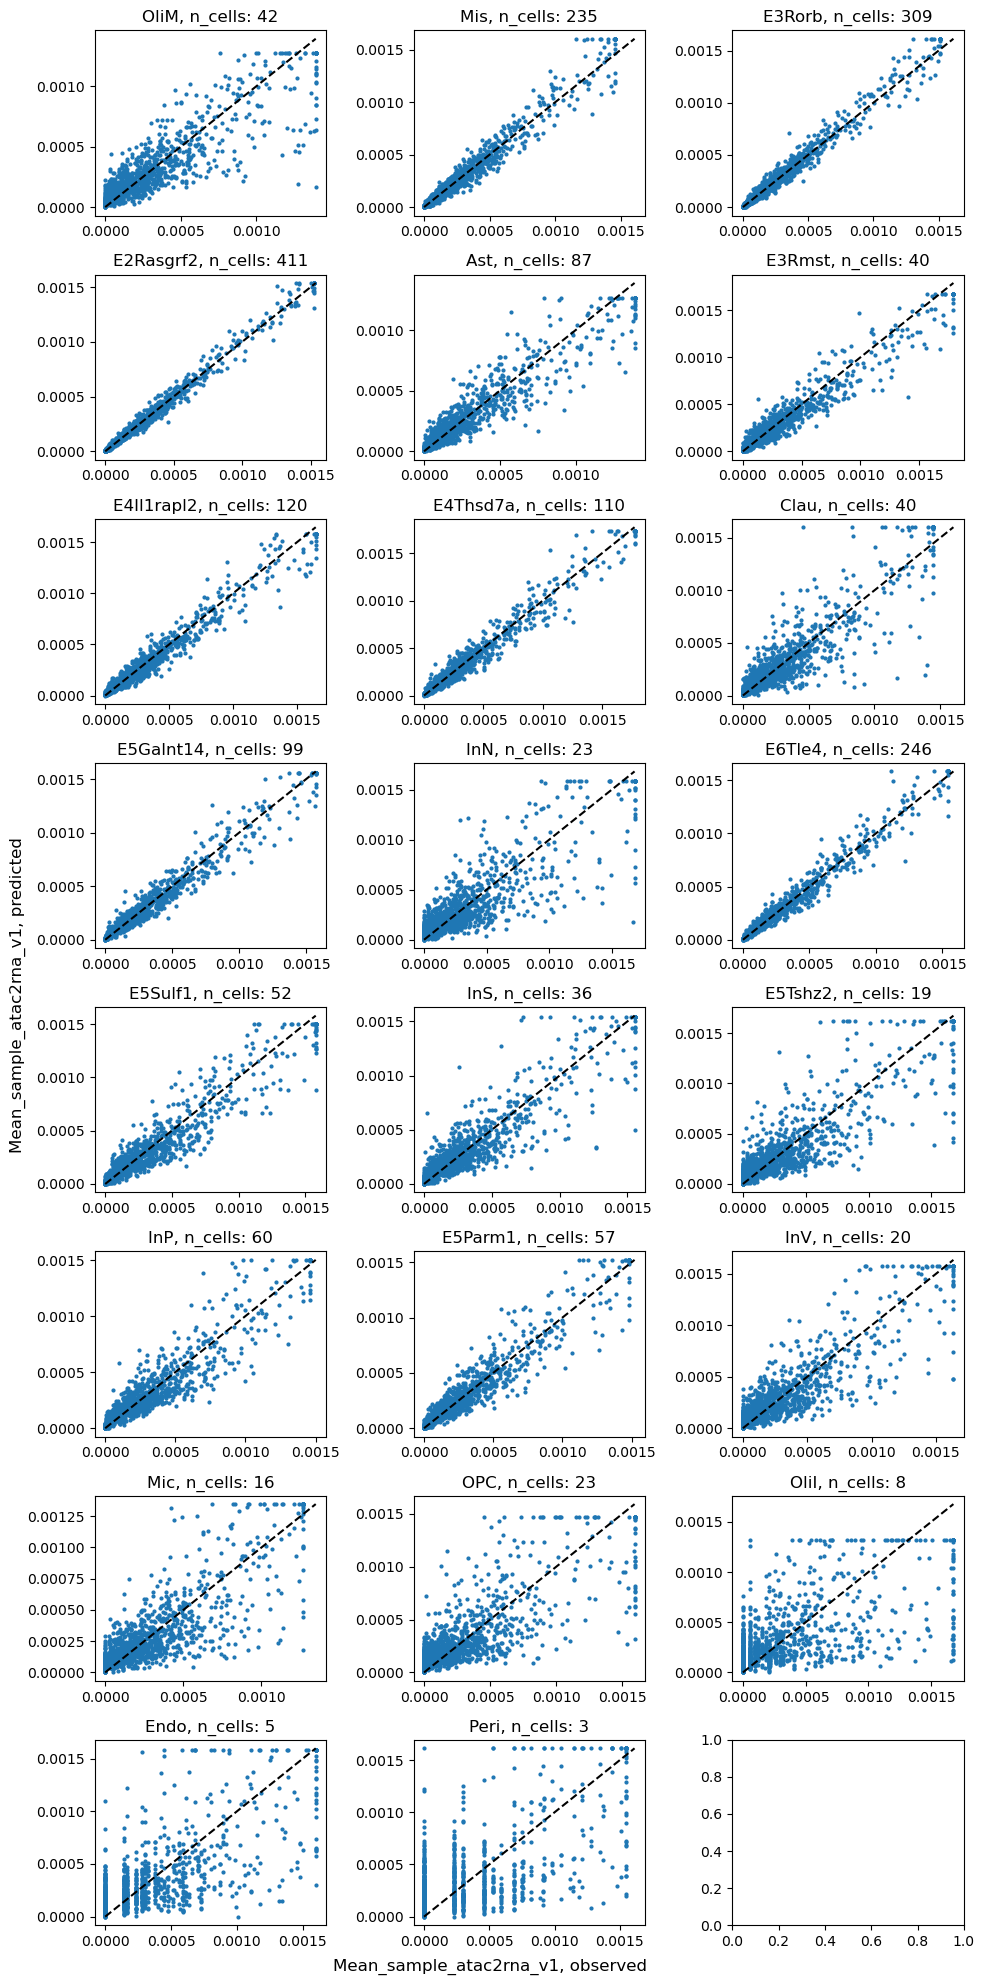

Clipping data to 95% quantile


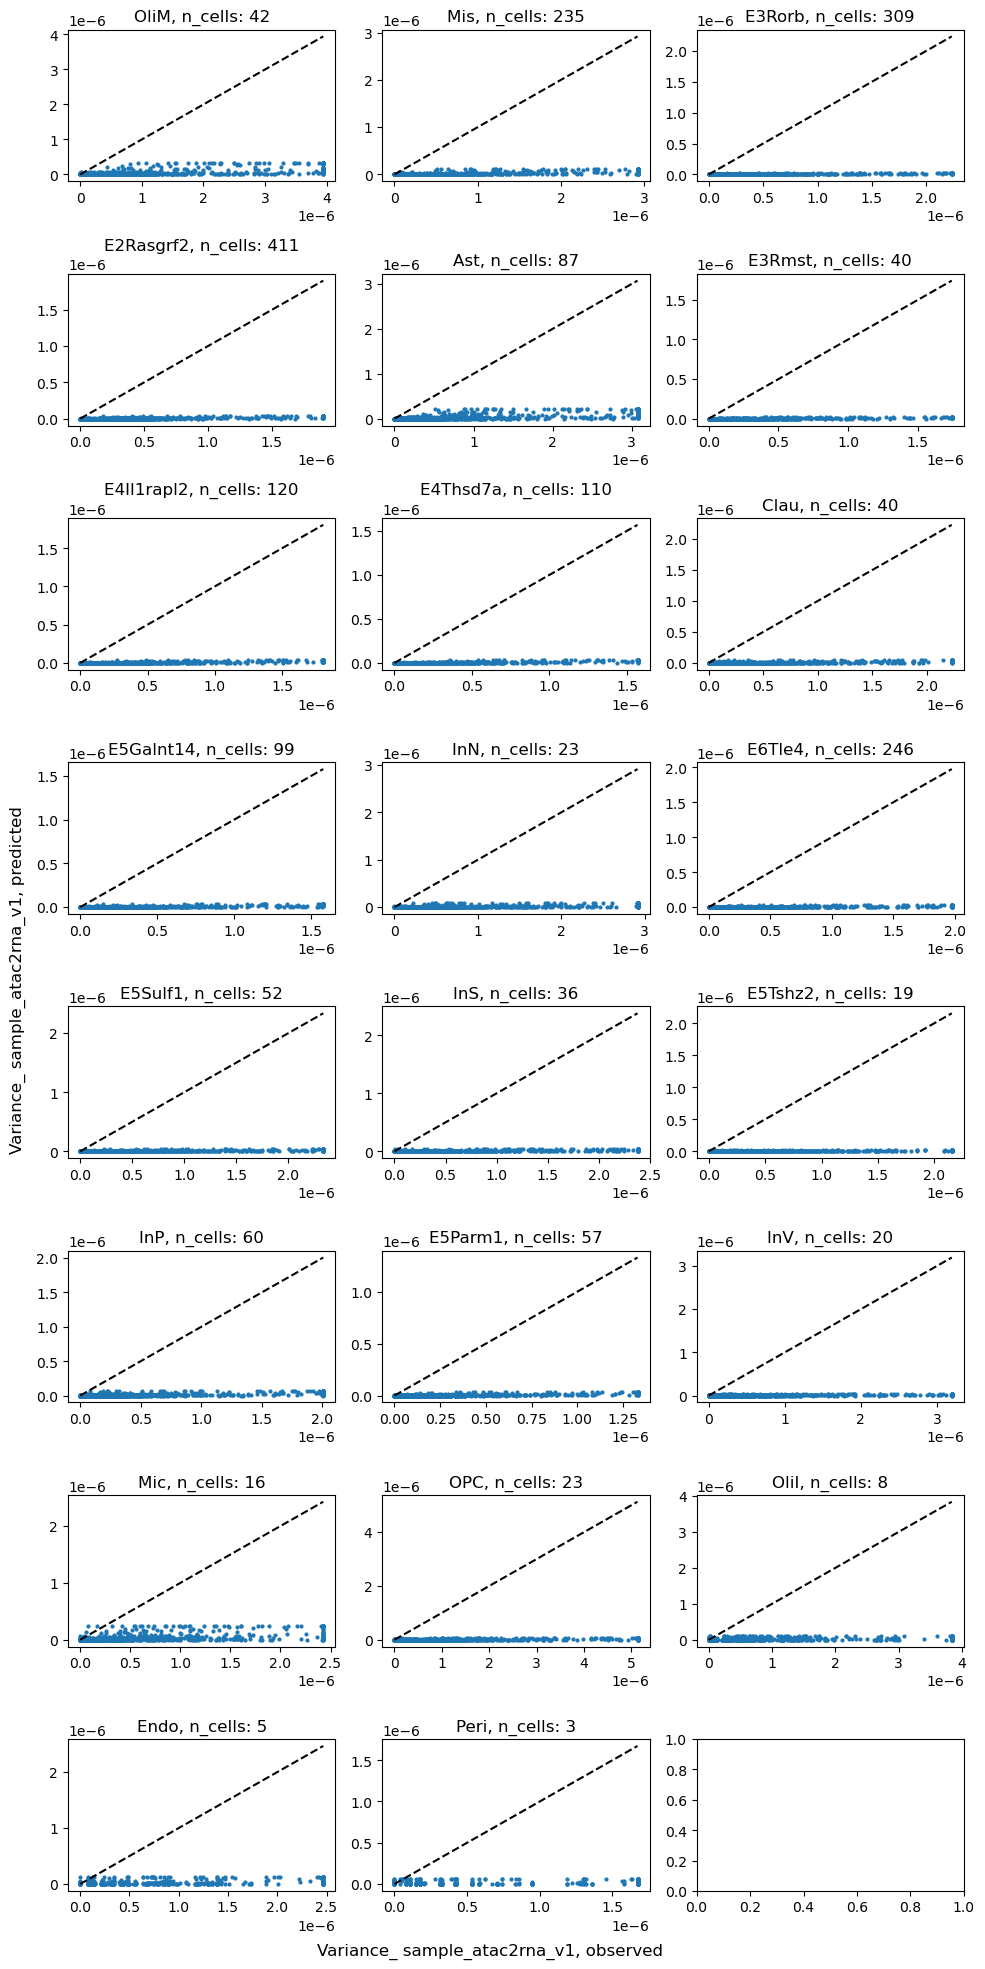

In [24]:
obs_norm = normalize_counts(obs_rna)

outputs = "/data/mikulik/mnt_polarbear_exp/"
subdirs = ["mlptranslator", "inntranslator"]
scaled_obs_dir = {}
for subdir in subdirs:
    for file in os.listdir(os.path.join(outputs, subdir)):
        if "atac2rna" in file:
            print(file)
            print(os.path.join(outputs, subdir, file, "prediction/stats.zarr"))
            pred_mean, pred_var = get_reconstructed_cross_modality(os.path.join(outputs, subdir, file))
            tmp_mean, tmp_var = get_mean_var_per_ct(test_cell_names, diff_genes_ind, obs_norm, pred_mean)
            plot_pred_vs_obs_ct(tmp_mean, title=f"Mean_{file}", clip=True, savefig=save_fig_dir)
            plot_pred_vs_obs_ct(tmp_var, title=f"Variance_ {file}", clip=True, savefig=save_fig_dir)
            # plot_pred_vs_obs_ct(tmp_mean, clip=False)
            # plot_pred_vs_obs_ct(tmp_var, title="Variance", clip=False)

# RNAVAE

In [26]:
obs_norm = normalize_counts(obs_rna, logscale=True)
mean_pred_norm = normalize_counts(mean_pred_rna, logscale=True)

Clipping data to 95% quantile


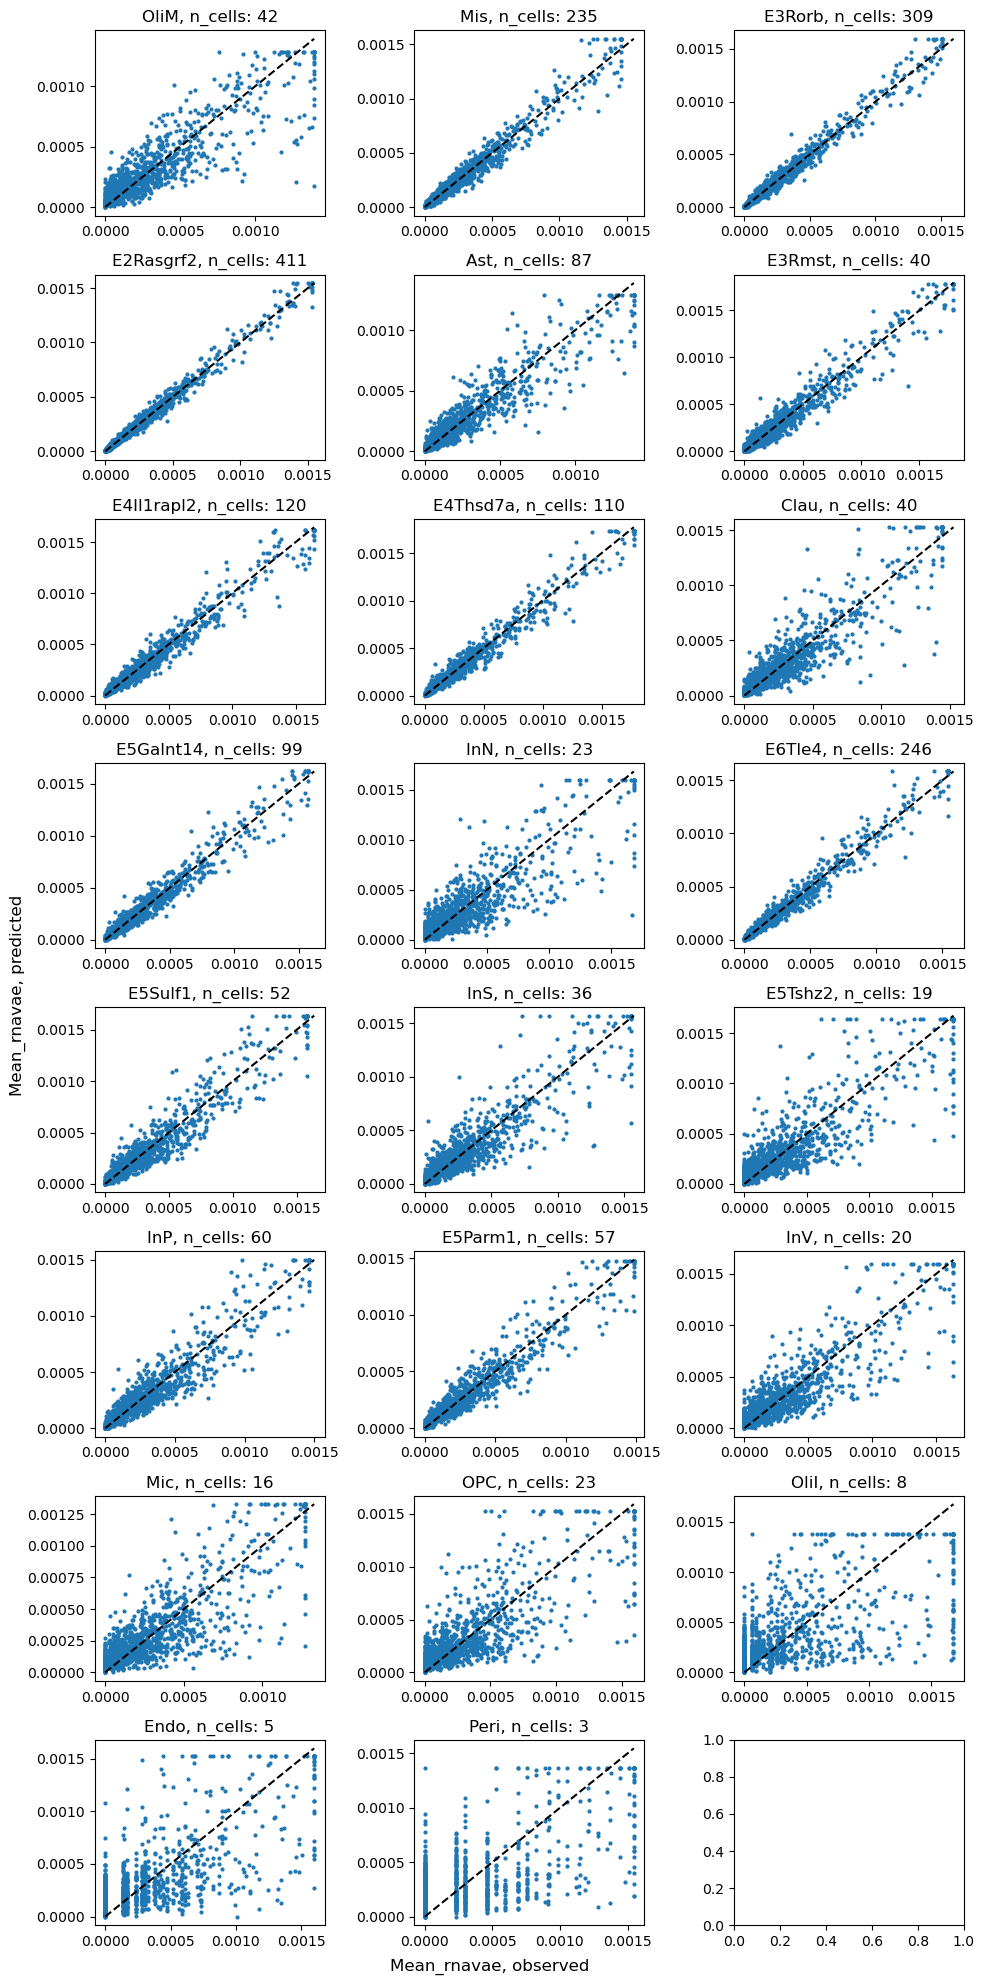

Clipping data to 95% quantile


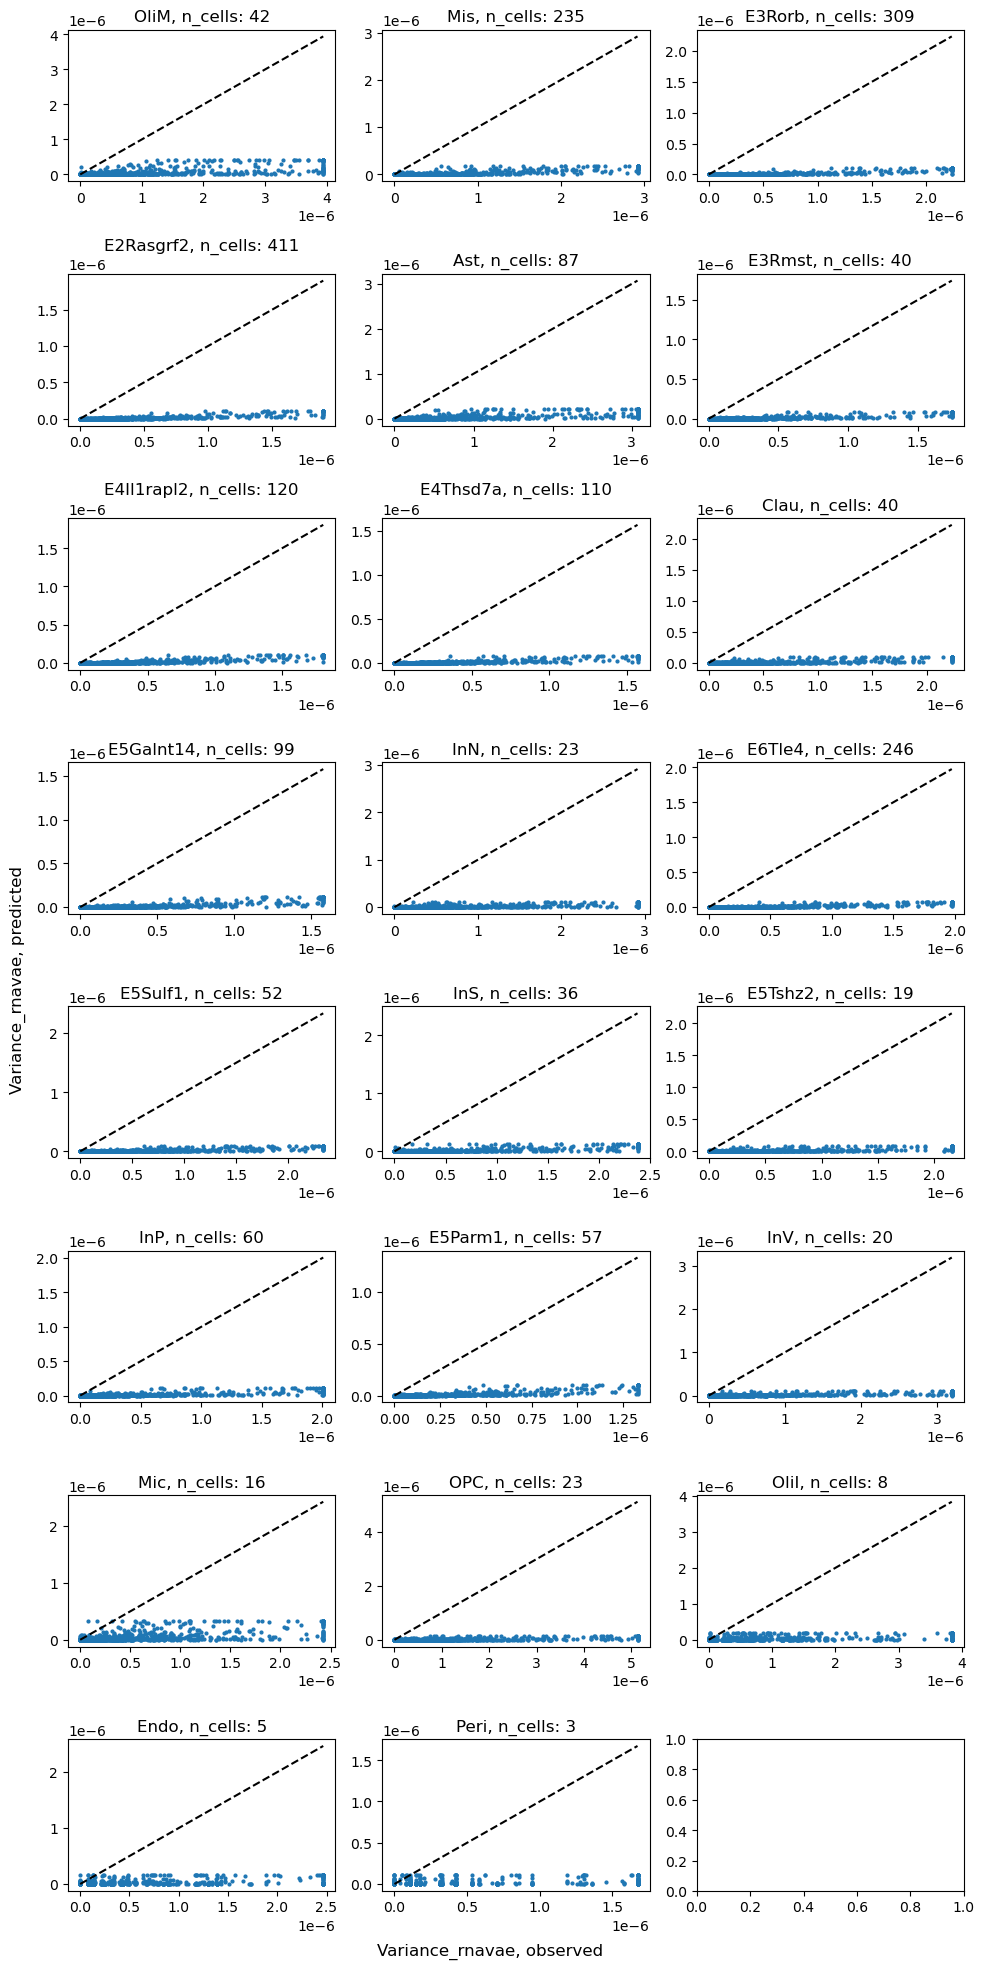

In [53]:
# Normalized counts
tmp_mean, tmp_var = get_mean_var_per_ct(test_cell_names, diff_genes_ind, obs_norm, mean_pred_norm)
plot_pred_vs_obs_ct(tmp_mean, title="Mean_rnavae", savefig=save_fig_dir)
plot_pred_vs_obs_ct(tmp_var, title="Variance_rnavae", savefig=save_fig_dir)
# plot_pred_vs_obs_ct(tmp_mean, clip=False)
# plot_pred_vs_obs_ct(tmp_var, title="Variance", clip=False)

Clipping data to 95% quantile


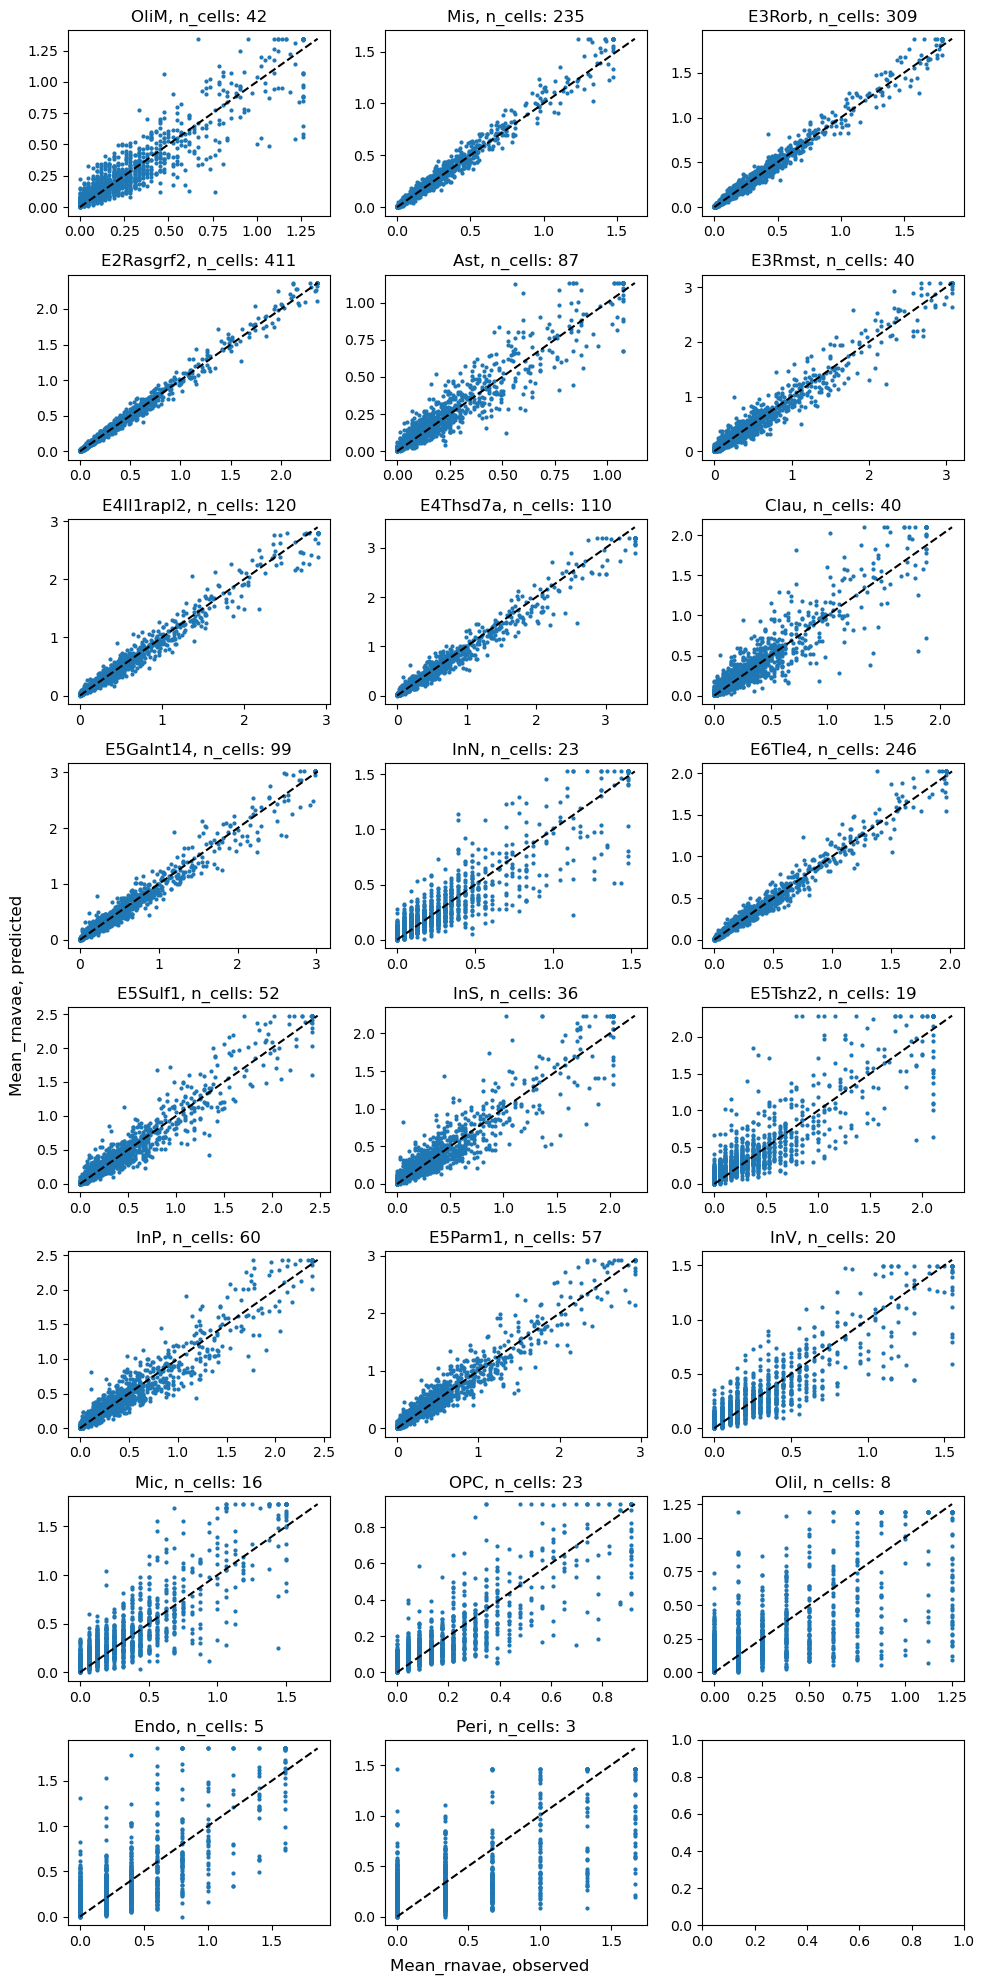

Clipping data to 95% quantile


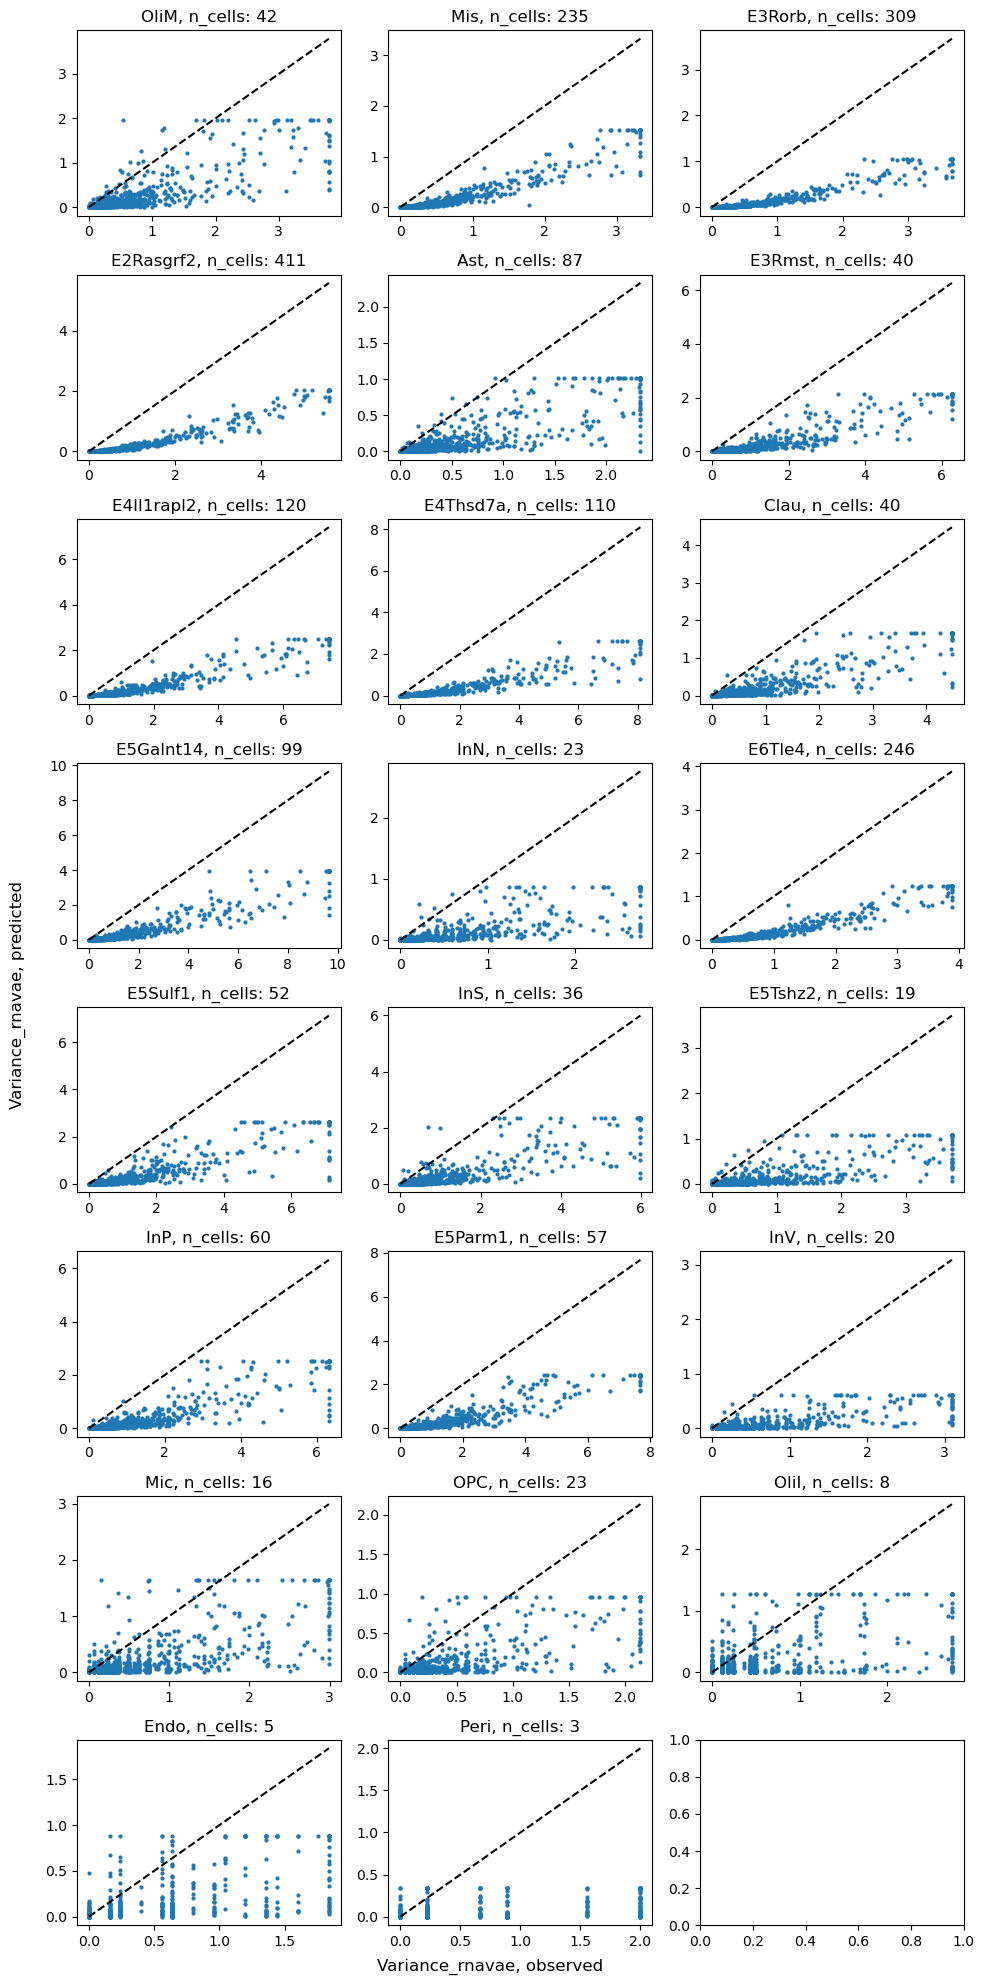

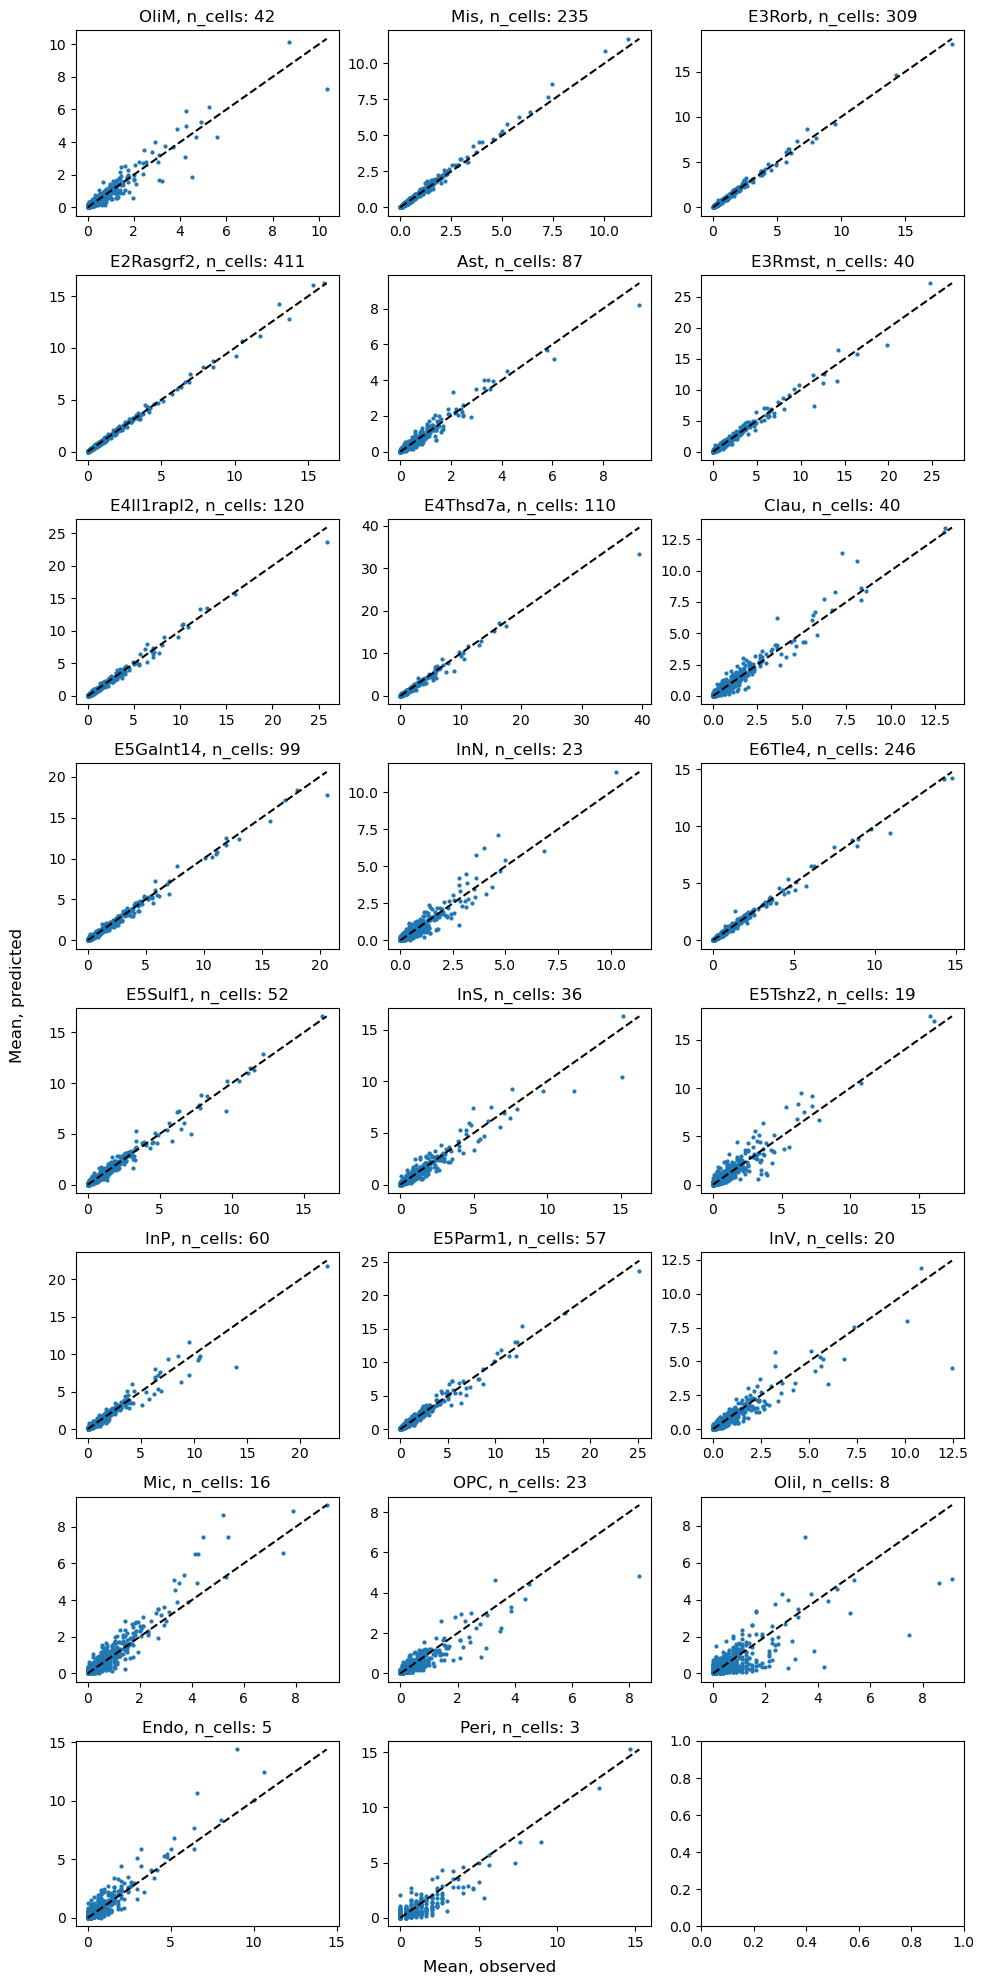

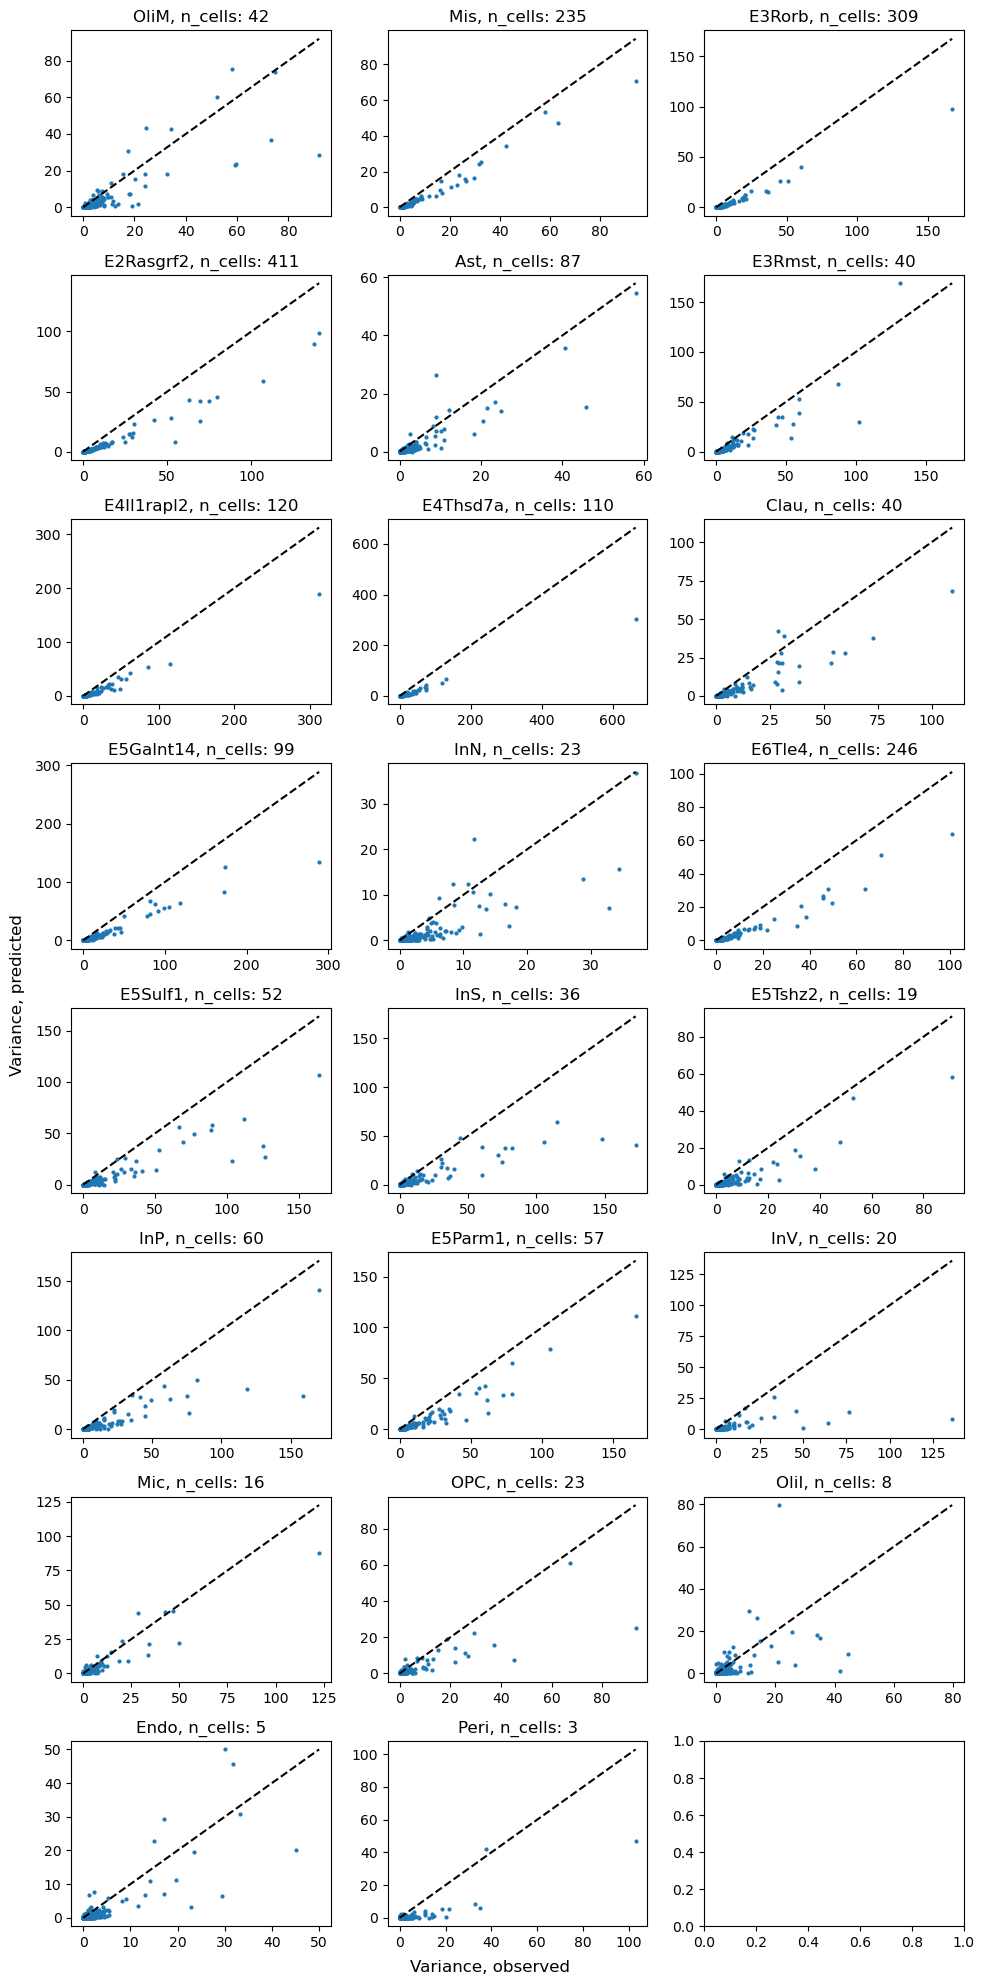

In [62]:
tmp_mean, tmp_var = get_mean_var_per_ct(test_cell_names, diff_genes_ind, obs_rna, mean_pred_rna)
plot_pred_vs_obs_ct(tmp_mean, title="Mean_rnavae", savefig=save_fig_dir)
plot_pred_vs_obs_ct(tmp_var, title="Variance_rnavae", savefig=save_fig_dir)
# plot_pred_vs_obs_ct(tmp_mean, clip=False)
# plot_pred_vs_obs_ct(tmp_var, title="Variance", clip=False)